<a href="https://colab.research.google.com/github/LarcesUece/UECE-RNP-PMon2022/blob/main/Analise_BBR_Esmond_VazaoFINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### LIB (R)

In [1]:
# bibliotecas do python
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# bibliotecas do R
base = importr('base')
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
ts_analysis = ('urca','tseries','forecast','e1071','Metrics')

from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector(ts_analysis))

(as ‘lib’ is unspecified)




















































































	‘/tmp/RtmpD0vBSC/downloaded_packages’



<rpy2.rinterface_lib.sexp.NULLType object at 0x7fe433a9f0a0> [RTYPES.NILSXP]

In [3]:
# importando as bibliotecas do R usadas para predição
# acho que so precisa importar uma vez. (demora)

urca = importr('urca')
tseries = importr('tseries')
forecast = importr('forecast')
e1071 = importr('e1071')
metrics = importr('Metrics')

In [4]:
# %R - "linha mágica" - retorna valor como objeto python

# %%R - "célula mágica" - nao retorna valor mas consegue passar input e output  

# Arguments
# -i  -  variaveis de input
# -o  -  variaveis de output
# -h  -  altura do plot
# -w  -  largura do plot


%load_ext rpy2.ipython

### Throughput Total (PRA - Remoção de Erros de Ciclo)

In [553]:
TS = pd.read_csv(r'/content/bbr esmond data 10-18-2022.csv')

In [555]:
 # Remoção de outiliers (ciclos de baixa amplitude)
TS = TS.drop(568)
TS = TS.drop(569)
TS = TS.drop(823)
TS = TS.drop(776)
TS = TS.drop(571)
TS = TS.drop(572)
TS = TS.drop(573)
TS = TS.drop(574)
TS = TS.drop(690)
TS = TS.drop(820)
TS = TS.drop(605)
TS = TS.drop(192)
TS = TS.drop(607)
TS = TS.drop(608)
TS = TS.drop(609)
TS = TS.drop(610)
TS = TS.drop(6)
TS = TS.drop(72)
TS = TS.drop(53)
TS = TS.drop(692)
TS = TS.drop(693)
TS = TS.drop(694)
TS = TS.drop(623)
TS = TS.drop(624)
TS = TS.drop(625)
TS = TS.drop(626)
TS = TS.drop(627)
TS = TS.drop(628)
TS = TS.drop(737)
TS = TS.drop(193)
TS = TS.drop(194)
TS = TS.drop(195)
TS = TS.drop(196)

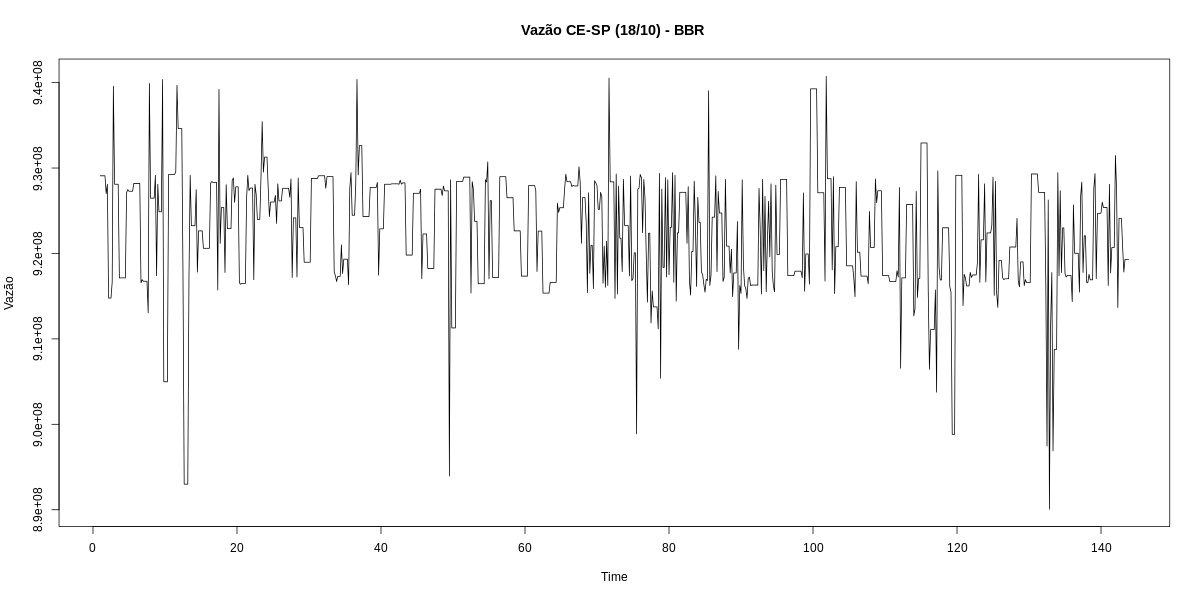

In [556]:
%%R -i TS -h 600 -w 1200

TS_R = TS

TSbbr = ts(TS_R[,2], start = c(1, 1), frequency = 6)

plot(TSbbr, main = "Vazão CE-SP (18/10) - BBR ", ylab = "Vazão")


### Funcoes para destacar a media e variancia

In [482]:
%%R 

media = function(ts){
  #Média ao longo da série
  y = c()
  cont = 0
  for(i in 1:length(ts)){
    cont = cont + ts[i]
    y = append(y, cont/i)
  }
  med = ts(y, start = c(1, 1), frequency = 6)
  return(med)
}

variancia = function(ts){
  #variância ao longo da série
  y = c()
  for(i in 1:length(ts)){
    y = append(y, var(ts[1:i]))
  }
  var = ts(y, start = c(1, 1), frequency = 6)
  return(var)
}

### Decomposição

In [483]:
%%R -w 700 -h 400 # Decomposição da Série (Observação de tendencia e sazonaliadade)

tsadditive = decompose(TSbbr, type = "additive")
tsmult = decompose(TSbbr, type = "multiplicative")

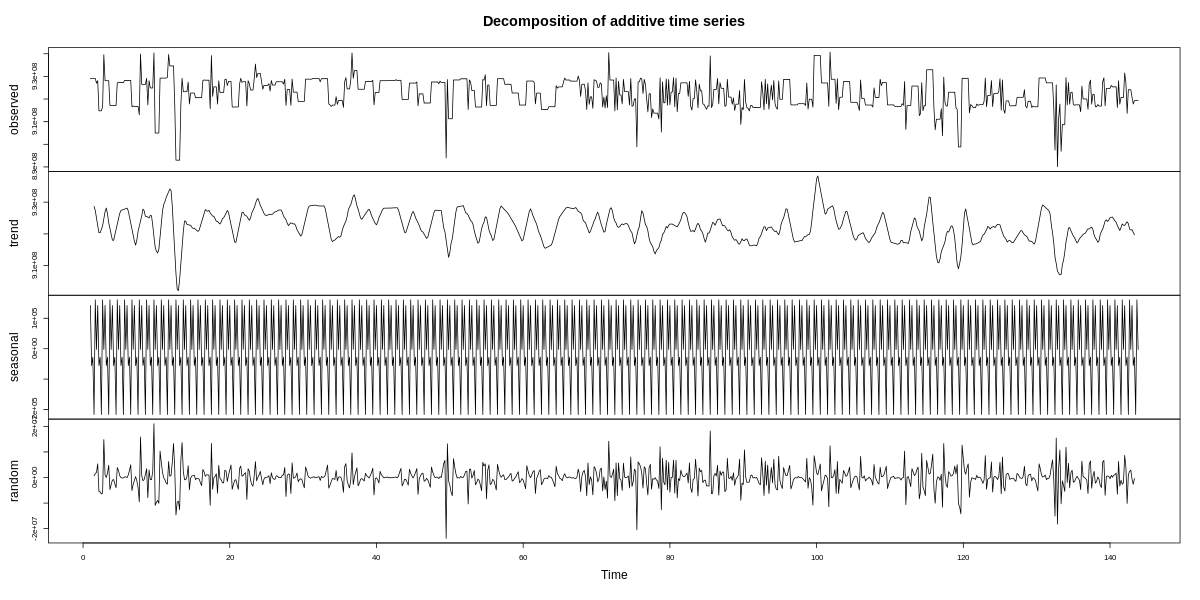

In [485]:
%%R -h 600 -w 1200

plot(tsadditive)

In [581]:
%%R #Extraindo a tendencia e sazonalidade

myts = TSbbr - tsadditive$seasonal

In [587]:
%%R -w 1200

myts_final = myts - tsadditive$trend

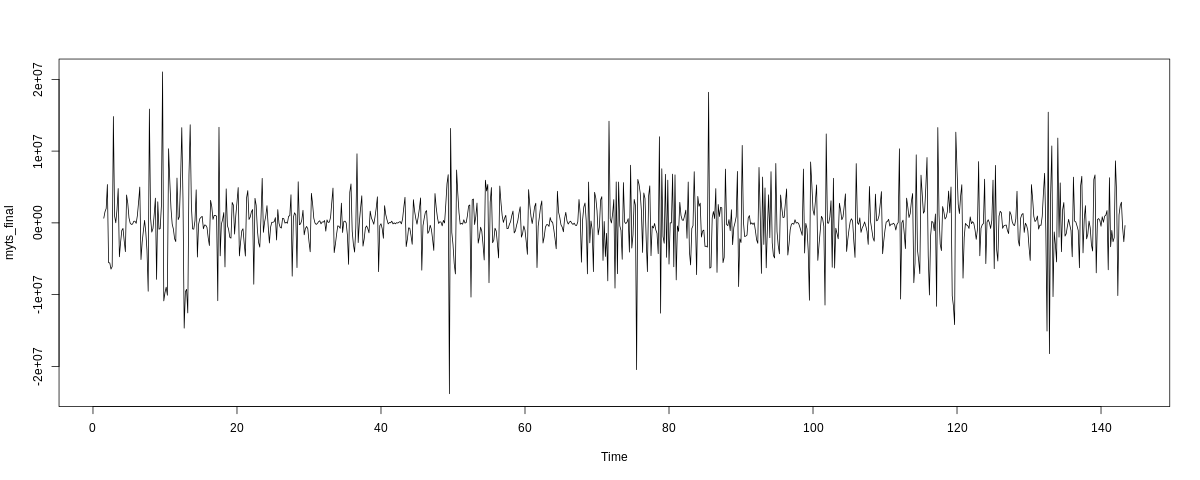

In [588]:
%%R -w 1200

plot(myts_final)

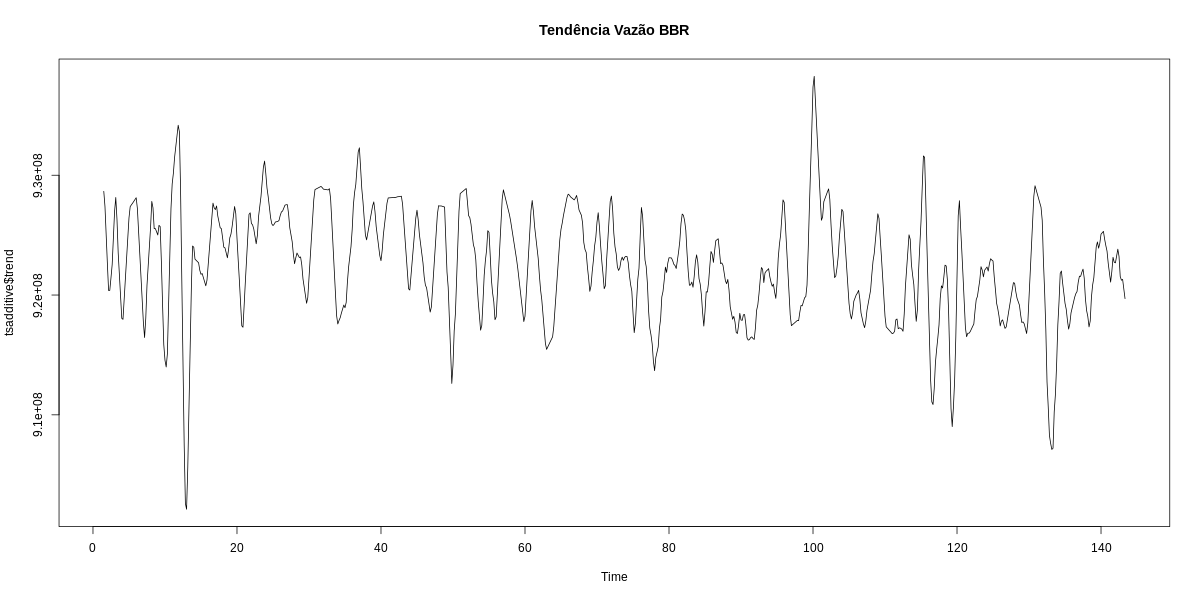

In [486]:
%%R -h 600 -w 1200 # Destacando a Tendencia

plot(tsadditive$trend, main = 'Tendência Vazão BBR')


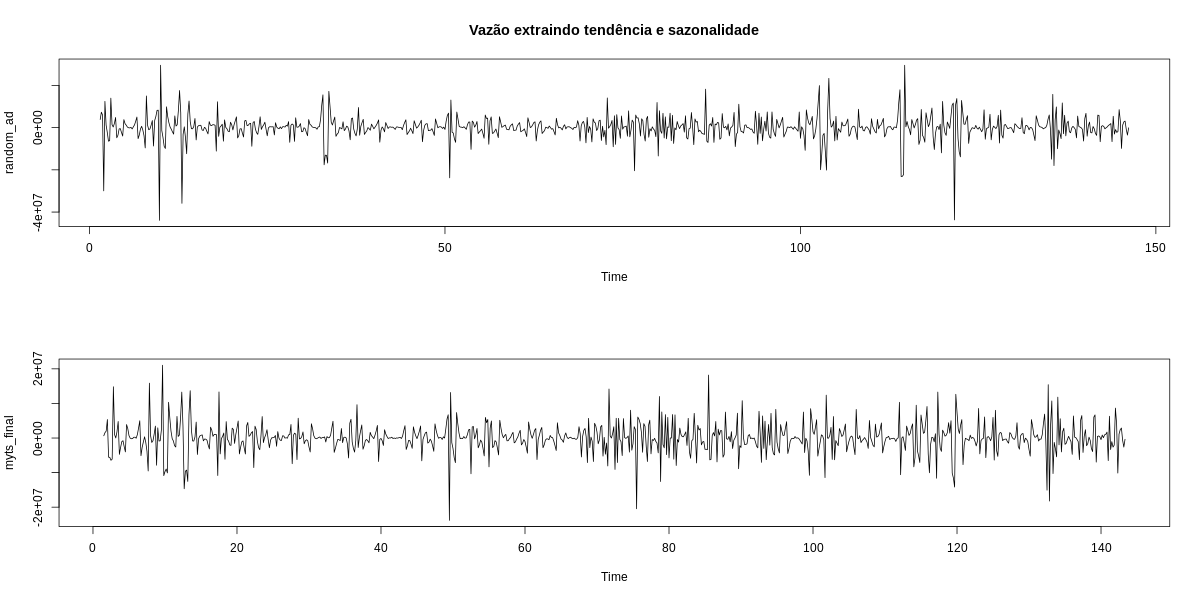

In [590]:
%%R -h 600 -w 1200 # Extraindo a Tendência e a Sazonalidade (Decomposição clássica aditiva)

par(mfrow = c(2,1))
plot(random_ad, main = 'Vazão extraindo tendência e sazonalidade')
plot(myts_final)

In [507]:
%%R # Excluindo valores nulos que restam da decomposição

random_ad = na.omit(random_ad)

In [593]:
%%R 
myts_final = na.omit(myts_final)

### Vizualizaçao da media e variancia da serie original

In [651]:
%%R -h 400 -w 1200

mean = media(random_ad)
var = variancia(random_ad)

In [594]:
%%R -h 400 -w 1200

mean = media(myts_final)
var = variancia(myts_final)

In [652]:
%%R -h 400 -w 1200

mean_or = media(TSbbr)
var_or = variancia(TSbbr)

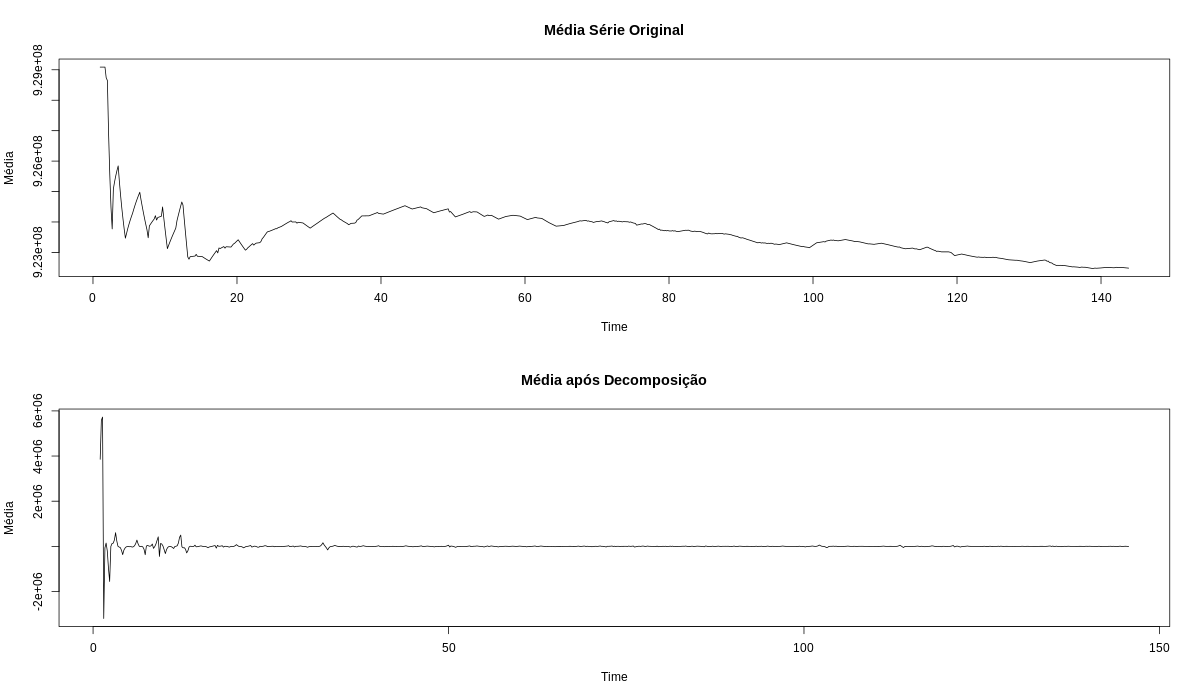

In [653]:
%%R -h 700 -w 1200

par(mfrow = c(2,1))
plot(mean_or, main = 'Média Série Original', ylab = "Média")
plot(mean, main = 'Média após Decomposição', ylab = 'Média')

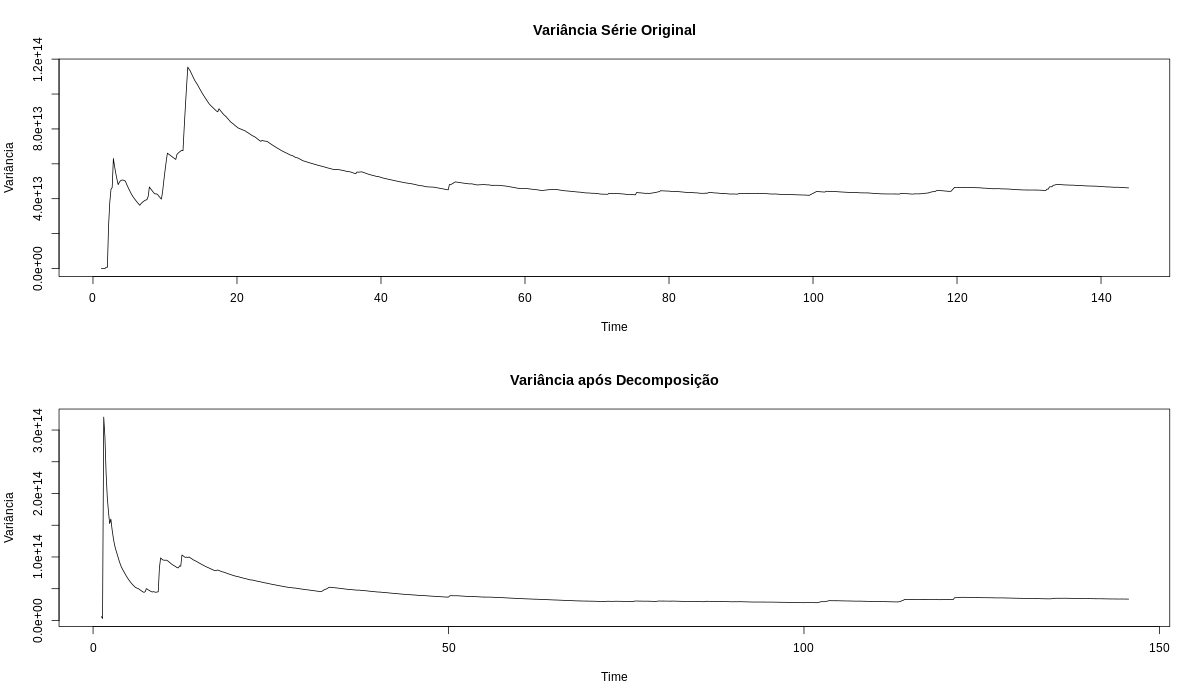

In [654]:
%%R -h 700 -w 1200

par(mfrow = c(2,1))
plot(var_or, main = 'Variância Série Original', ylab = "Variância")
plot(var, main = 'Variância após Decomposição', ylab = 'Variância')

### Teste de Estacionariedade (Serie Total - Observação)

In [655]:
%%R -h 400 -w 1000 # Teste de estacionariedade para cada tipo de decomposição

kpss_add = ur.kpss(random_ad)
#kpss_mul = ur.kpss(random_mt)

adf_add = ur.df(random_ad)
#adf_mul = ur.df(random_mt)

In [597]:
%%R -h 400 -w 1000 # Teste de estacionariedade para cada tipo de decomposição

kpss_add = ur.kpss(myts_final)
#kpss_mul = ur.kpss(random_mt)

adf_add = ur.df(myts_final)
#adf_mul = ur.df(random_mt)

In [656]:
%%R

print(kpss_add)
#print(kpss_mul)

print(adf_add)
#print(adf_mul)


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.0033 


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -28.3223 



### Separar Conjuntos

In [657]:
%%R # Separar conjuntos de treino

conjunto_treino = c("mytsTrain3", 
                    "mytsTrain6",
                    "mytsTrain9", 
                    "mytsTrain12",
                    "mytsTrain15",
                    "mytsTrain18",
                    "mytsTrain21",
                    "mytsTrain24",
                    "mytsTrain27",
                    "mytsTrain30",
                    "mytsTrain33",
                    "mytsTrain36",
                    "mytsTrain39",
                    "mytsTrain42",
                    "mytsTrain45",
                    "mytsTrain48",
                    "mytsTrain51",
                    "mytsTrain54",
                    "mytsTrain57",
                    "mytsTrain60",
                    "mytsTrain63",
                    "mytsTrain66",
                    "mytsTrain69",
                    "mytsTrain72",
                    "mytsTrain75",
                    "mytsTrain78",
                    "mytsTrain81",
                    "mytsTrain84",
                    "mytsTrain87",
                    "mytsTrain90",
                    "mytsTrain93",
                    "mytsTrain96",
                    "mytsTrain99",
                    "mytsTrain102",
                    "mytsTrain105",
                    "mytsTrain108",
                    "mytsTrain111",
                    "mytsTrain114",
                    "mytsTrain117",
                    "mytsTrain120",
                    "mytsTrain123",
                    "mytsTrain126",
                    "mytsTrain129",
                    "mytsTrain132",
                    "mytsTrain135",
                    "mytsTrain138",
                    "mytsTrain141",
                    "mytsTrain144")


In [658]:
%%R

mytsTrain3 = window(random_ad, start = c(1,1), end = c(3,6))
mytsTrain6 = window(random_ad, start = c(1,1), end = c(6,6))
mytsTrain9 = window(random_ad, start = c(1,1), end = c(9,6))
mytsTrain12 = window(random_ad, start = c(1,1), end = c(12,6))
mytsTrain15 = window(random_ad, start = c(1,1), end = c(15,6))
mytsTrain18 = window(random_ad, start = c(1,1), end = c(18,6))
mytsTrain21 = window(random_ad, start = c(1,1), end = c(21,6))
mytsTrain24 = window(random_ad, start = c(1,1), end = c(24,6))
mytsTrain27 = window(random_ad, start = c(1,1), end = c(27,6))
mytsTrain30 = window(random_ad, start = c(1,1), end = c(30,6))
mytsTrain33 = window(random_ad, start = c(1,1), end = c(33,6))
mytsTrain36 = window(random_ad, start = c(1,1), end = c(36,6))
mytsTrain39 = window(random_ad, start = c(1,1), end = c(39,6))
mytsTrain42 = window(random_ad, start = c(1,1), end = c(42,6))
mytsTrain45 = window(random_ad, start = c(1,1), end = c(45,6))
mytsTrain48 = window(random_ad, start = c(1,1), end = c(48,6))
mytsTrain51 = window(random_ad, start = c(1,1), end = c(51,6))
mytsTrain54 = window(random_ad, start = c(1,1), end = c(54,6))
mytsTrain57 = window(random_ad, start = c(1,1), end = c(57,6))
mytsTrain60 = window(random_ad, start = c(1,1), end = c(60,6))
mytsTrain63 = window(random_ad, start = c(1,1), end = c(63,6))
mytsTrain66 = window(random_ad, start = c(1,1), end = c(66,6))
mytsTrain69 = window(random_ad, start = c(1,1), end = c(69,6))
mytsTrain72 = window(random_ad, start = c(1,1), end = c(72,6))
mytsTrain75 = window(random_ad, start = c(1,1), end = c(75,6))
mytsTrain78 = window(random_ad, start = c(1,1), end = c(78,6))
mytsTrain81 = window(random_ad, start = c(1,1), end = c(81,6))
mytsTrain84 = window(random_ad, start = c(1,1), end = c(84,6))
mytsTrain87 = window(random_ad, start = c(1,1), end = c(87,6))
mytsTrain90 = window(random_ad, start = c(1,1), end = c(90,6))
mytsTrain93 = window(random_ad, start = c(1,1), end = c(93,6))
mytsTrain96 = window(random_ad, start = c(1,1), end = c(96,6))
mytsTrain99 = window(random_ad, start = c(1,1), end = c(99,6))
mytsTrain102 = window(random_ad, start = c(1,1), end = c(102,6))
mytsTrain105 = window(random_ad, start = c(1,1), end = c(105,6))
mytsTrain108 = window(random_ad, start = c(1,1), end = c(108,6))
mytsTrain111 = window(random_ad, start = c(1,1), end = c(111,6))
mytsTrain114 = window(random_ad, start = c(1,1), end = c(114,6))
mytsTrain117 = window(random_ad, start = c(1,1), end = c(117,6))
mytsTrain120 = window(random_ad, start = c(1,1), end = c(120,6))
mytsTrain123 = window(random_ad, start = c(1,1), end = c(123,6))
mytsTrain126 = window(random_ad, start = c(1,1), end = c(126,6))
mytsTrain129 = window(random_ad, start = c(1,1), end = c(129,6))
mytsTrain132 = window(random_ad, start = c(1,1), end = c(132,6))
mytsTrain135 = window(random_ad, start = c(1,1), end = c(135,6))
mytsTrain138 = window(random_ad, start = c(1,1), end = c(138,6))
mytsTrain141 = window(random_ad, start = c(1,1), end = c(141,6))
#mytsTrain144 = window(random_ad, start = c(1,1), end = c(144,6))


In [659]:
%%R 

mytsTest4 = window(random_ad, start = c(4,1), end = c(4,6))
mytsTest7 = window(random_ad, start = c(7,1), end = c(7,6))
mytsTest10 = window(random_ad, start = c(10,1), end = c(10,6)) 
mytsTest13 = window(random_ad, start = c(13,1), end = c(13,6)) 
mytsTest16 = window(random_ad, start = c(16,1), end = c(16,6)) 
mytsTest19 = window(random_ad, start = c(19,1), end = c(19,6)) 
mytsTest22 = window(random_ad, start = c(22,1), end = c(22,6)) 
mytsTest25 = window(random_ad, start = c(25,1), end = c(25,6))
mytsTest28 = window(random_ad, start = c(28,1), end = c(28,6)) 
mytsTest31 = window(random_ad, start = c(31,1), end = c(31,6)) 
mytsTest34 = window(random_ad, start = c(34,1), end = c(34,6)) 
mytsTest37 = window(random_ad, start = c(37,1), end = c(37,6))
mytsTest40 = window(random_ad, start = c(40,1), end = c(40,6)) 
mytsTest43 = window(random_ad, start = c(43,1), end = c(43,6)) 
mytsTest46 = window(random_ad, start = c(46,1), end = c(46,6)) 
mytsTest49 = window(random_ad, start = c(49,1), end = c(49,6))
mytsTest52 = window(random_ad, start = c(52,1), end = c(52,6)) 
mytsTest55 = window(random_ad, start = c(55,1), end = c(55,6)) 
mytsTest58 = window(random_ad, start = c(58,1), end = c(58,6)) 
mytsTest61 = window(random_ad, start = c(61,1), end = c(61,6))
mytsTest64 = window(random_ad, start = c(64,1), end = c(64,6))
mytsTest67 = window(random_ad, start = c(67,1), end = c(67,6))
mytsTest70 = window(random_ad, start = c(70,1), end = c(70,6))
mytsTest73 = window(random_ad, start = c(73,1), end = c(73,6))
mytsTest76 = window(random_ad, start = c(76,1), end = c(76,6))
mytsTest79 = window(random_ad, start = c(79,1), end = c(79,6))
mytsTest82 = window(random_ad, start = c(82,1), end = c(82,6))
mytsTest85 = window(random_ad, start = c(85,1), end = c(85,6))
mytsTest88 = window(random_ad, start = c(88,1), end = c(88,6))
mytsTest91 = window(random_ad, start = c(91,1), end = c(91,6))
mytsTest94 = window(random_ad, start = c(94,1), end = c(94,6))
mytsTest97 = window(random_ad, start = c(97,1), end = c(97,6))
mytsTest100 = window(random_ad, start = c(100,1), end = c(100,6))
mytsTest103 = window(random_ad, start = c(103,1), end = c(103,6))
mytsTest106 = window(random_ad, start = c(106,1), end = c(106,6))
mytsTest109 = window(random_ad, start = c(109,1), end = c(109,6))
mytsTest112 = window(random_ad, start = c(112,1), end = c(112,6))
mytsTest115 = window(random_ad, start = c(115,1), end = c(115,6))
mytsTest118 = window(random_ad, start = c(118,1), end = c(118,6))
mytsTest121 = window(random_ad, start = c(121,1), end = c(121,6))
mytsTest124 = window(random_ad, start = c(124,1), end = c(124,6))
mytsTest127 = window(random_ad, start = c(127,1), end = c(127,6))
mytsTest130 = window(random_ad, start = c(130,1), end = c(130,6))
mytsTest133 = window(random_ad, start = c(133,1), end = c(133,6))
mytsTest136 = window(random_ad, start = c(136,1), end = c(136,6))
mytsTest139 = window(random_ad, start = c(139,1), end = c(139,6))
mytsTest142 = window(random_ad, start = c(142,1), end = c(142,6))
#mytsTest145 = window(random_ad, start = c(145,1), end = c(145,6))


### FAC

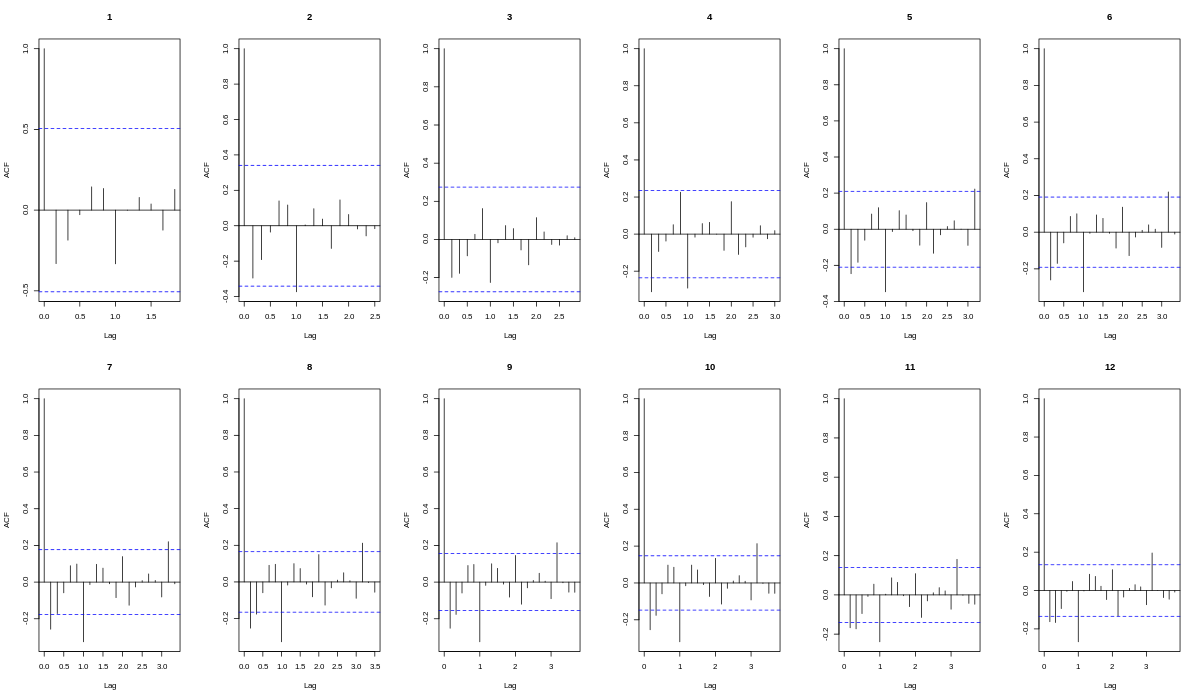

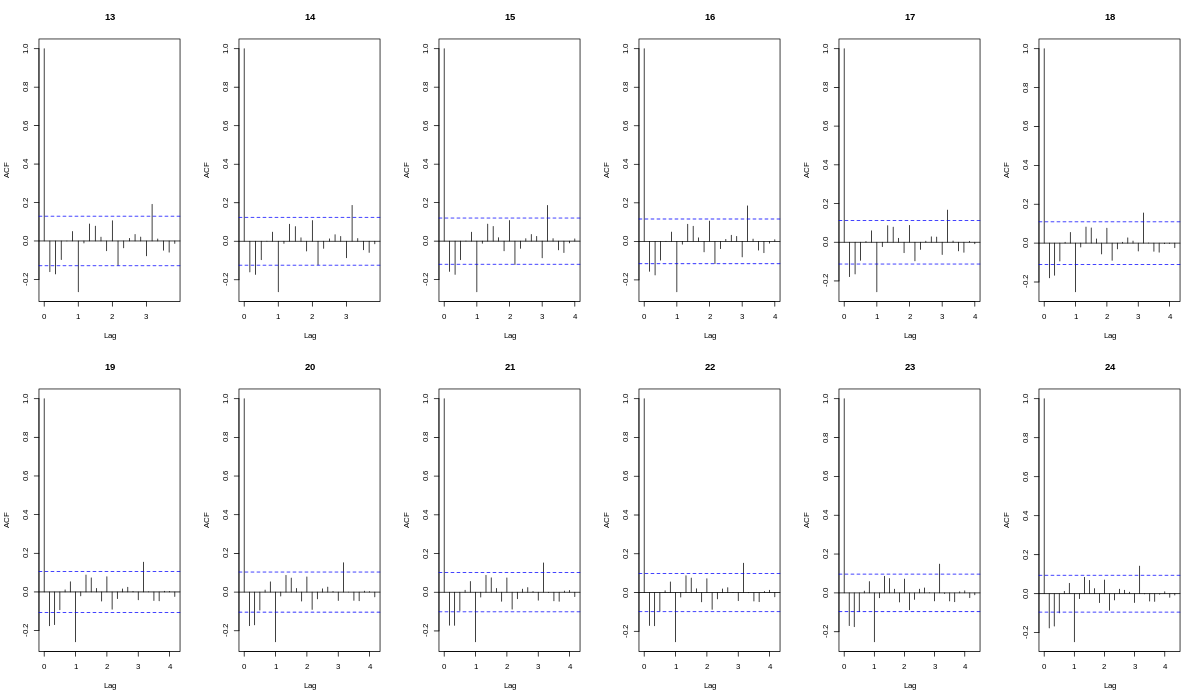

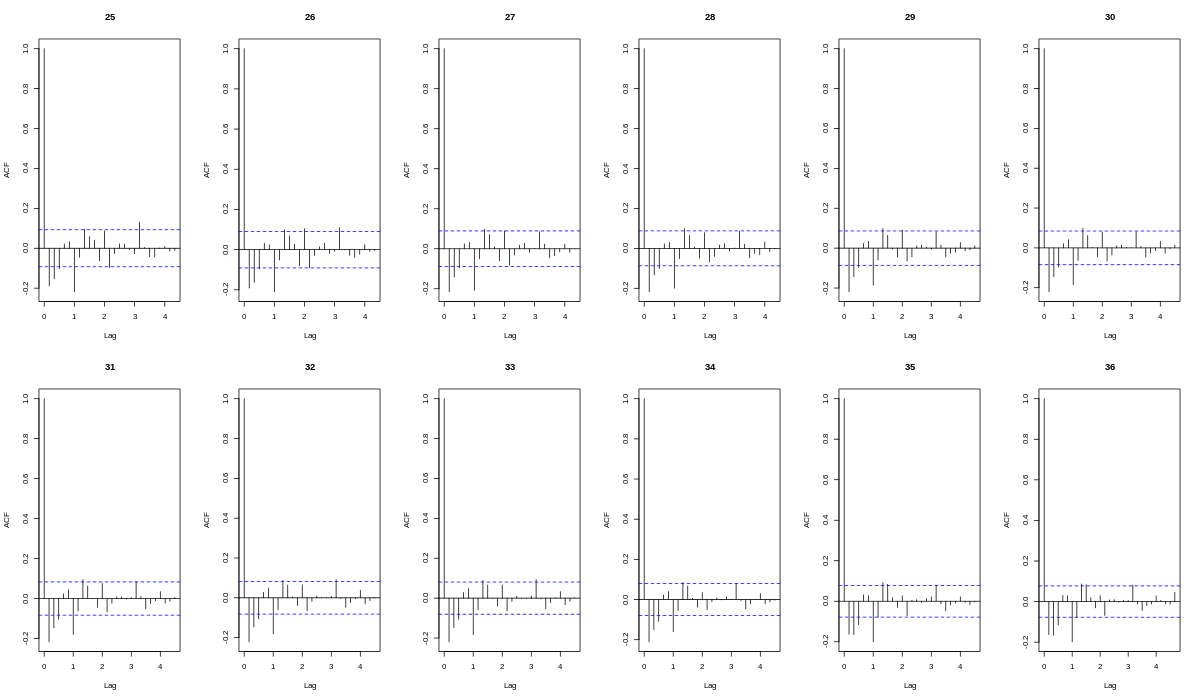

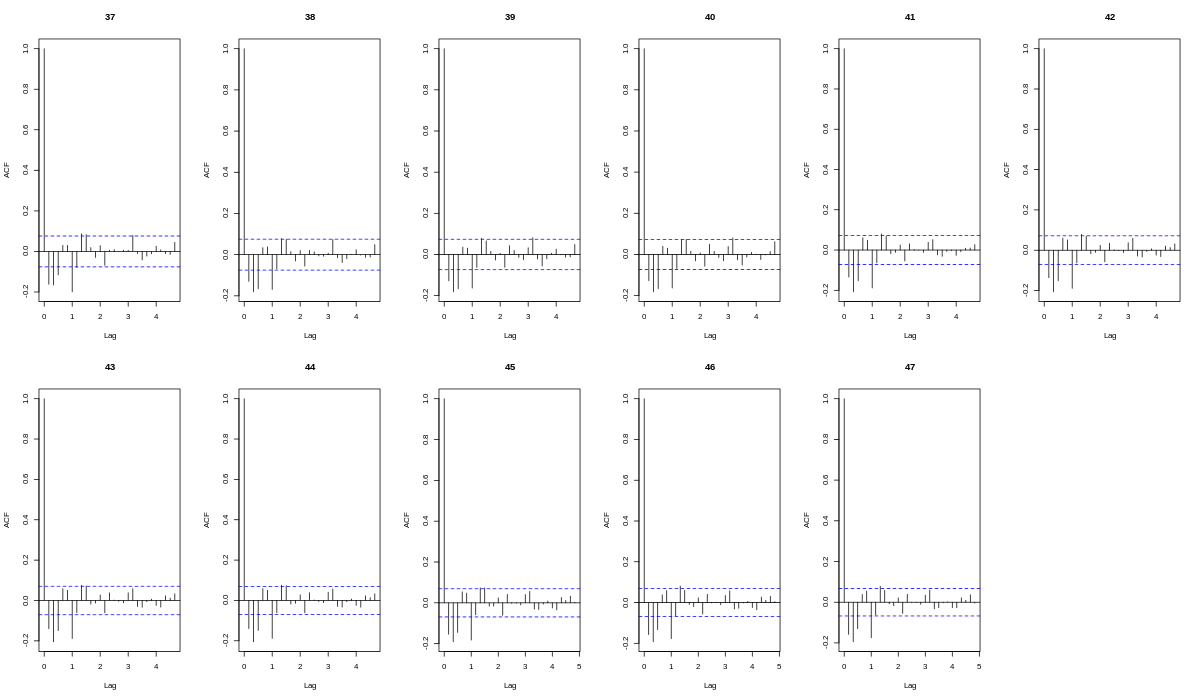

In [617]:
%%R -w 1200 -h 700 # Autocorrelação dos ciclos

par(mfrow = c(2,6))
acf(mytsTrain3, main = "1")
acf(mytsTrain6, main = "2")
acf(mytsTrain9, main = "3")
acf(mytsTrain12, main = "4")
acf(mytsTrain15, main = "5")
acf(mytsTrain18, main = "6")
acf(mytsTrain21, main = "7")
acf(mytsTrain24, main = "8")
acf(mytsTrain27, main = "9")
acf(mytsTrain30, main = "10")
acf(mytsTrain33, main = "11")
acf(mytsTrain36, main = "12")
acf(mytsTrain39, main = "13")
acf(mytsTrain42, main = "14")
acf(mytsTrain45, main = "15")
acf(mytsTrain48, main = "16")
acf(mytsTrain51, main = "17")
acf(mytsTrain54, main = "18")
acf(mytsTrain57, main = "19")
acf(mytsTrain60, main = "20")
acf(mytsTrain63, main = "21")
acf(mytsTrain66, main = "22")
acf(mytsTrain69, main = "23")
acf(mytsTrain72, main = "24")
acf(mytsTrain75, main = "25")
acf(mytsTrain78, main = "26")
acf(mytsTrain81, main = "27")
acf(mytsTrain84, main = "28")
acf(mytsTrain87, main = "29")
acf(mytsTrain90, main = "30")
acf(mytsTrain93, main = "31")
acf(mytsTrain96, main = "32")
acf(mytsTrain99, main = "33")
acf(mytsTrain102, main = "34")
acf(mytsTrain105, main = "35")
acf(mytsTrain108, main = "36")
acf(mytsTrain111, main = "37")
acf(mytsTrain114, main = "38")
acf(mytsTrain117, main = "39")
acf(mytsTrain120, main = "40")
acf(mytsTrain123, main = "41")
acf(mytsTrain126, main = "42")
acf(mytsTrain129, main = "43")
acf(mytsTrain132, main = "44")
acf(mytsTrain135, main = "45")
acf(mytsTrain138, main = "46")
acf(mytsTrain141, main = "47")


### Teste de Estacionariedade para todos os conjuntos

In [660]:
%%R # Testes de Estacionariedade (PRA)

adf_test = c(
  adf.test(mytsTrain3)$statistic, #3
  adf.test(mytsTrain6)$statistic,
  adf.test(mytsTrain9)$statistic,
  adf.test(mytsTrain12)$statistic, #30
  adf.test(mytsTrain15)$statistic,
  adf.test(mytsTrain18)$statistic,
  adf.test(mytsTrain21)$statistic,
  adf.test(mytsTrain24)$statistic,
  adf.test(mytsTrain27)$statistic,
  adf.test(mytsTrain30)$statistic,
  adf.test(mytsTrain33)$statistic,
  adf.test(mytsTrain36)$statistic,
  adf.test(mytsTrain39)$statistic,
  adf.test(mytsTrain42)$statistic,
  adf.test(mytsTrain45)$statistic,
  adf.test(mytsTrain48)$statistic,
  adf.test(mytsTrain51)$statistic,
  adf.test(mytsTrain54)$statistic,
  adf.test(mytsTrain57)$statistic,
  adf.test(mytsTrain60)$statistic,
  adf.test(mytsTrain63)$statistic,
  adf.test(mytsTrain66)$statistic,
  adf.test(mytsTrain69)$statistic,
  adf.test(mytsTrain72)$statistic,
  adf.test(mytsTrain75)$statistic,
  adf.test(mytsTrain78)$statistic,
  adf.test(mytsTrain81)$statistic,
  adf.test(mytsTrain84)$statistic,
  adf.test(mytsTrain87)$statistic,
  adf.test(mytsTrain90)$statistic,
  adf.test(mytsTrain93)$statistic,
  adf.test(mytsTrain96)$statistic,
  adf.test(mytsTrain99)$statistic,
  adf.test(mytsTrain102)$statistic,
  adf.test(mytsTrain105)$statistic,
  adf.test(mytsTrain108)$statistic,
  adf.test(mytsTrain111)$statistic,
  adf.test(mytsTrain114)$statistic,
  adf.test(mytsTrain117)$statistic,
  adf.test(mytsTrain120)$statistic,
  adf.test(mytsTrain123)$statistic,
  adf.test(mytsTrain126)$statistic,
  adf.test(mytsTrain129)$statistic,
  adf.test(mytsTrain132)$statistic,
  adf.test(mytsTrain135)$statistic,
  adf.test(mytsTrain138)$statistic,
  adf.test(mytsTrain141)$statistic,
  adf.test(mytsTrain144)$statistic)

In [661]:
%%R 
  adf_test_pv = conjnuto_treino = c(
  adf.test(mytsTrain3)$p.value, #3
  adf.test(mytsTrain6)$p.value,
  adf.test(mytsTrain9)$p.value,
  adf.test(mytsTrain12)$p.value, #30
  adf.test(mytsTrain15)$p.value,
  adf.test(mytsTrain18)$p.value,
  adf.test(mytsTrain21)$p.value,
  adf.test(mytsTrain24)$p.value,
  adf.test(mytsTrain27)$p.value,
  adf.test(mytsTrain30)$p.value,
  adf.test(mytsTrain33)$p.value,
  adf.test(mytsTrain36)$p.value,
  adf.test(mytsTrain39)$p.value,
  adf.test(mytsTrain42)$p.value,
  adf.test(mytsTrain45)$p.value,
  adf.test(mytsTrain48)$p.value,
  adf.test(mytsTrain51)$p.value,
  adf.test(mytsTrain54)$p.value,
  adf.test(mytsTrain57)$p.value,
  adf.test(mytsTrain60)$p.value,
  adf.test(mytsTrain63)$p.value,
  adf.test(mytsTrain66)$p.value,
  adf.test(mytsTrain69)$p.value,
  adf.test(mytsTrain72)$p.value,
  adf.test(mytsTrain75)$p.value,
  adf.test(mytsTrain78)$p.value,
  adf.test(mytsTrain81)$p.value,
  adf.test(mytsTrain84)$p.value,
  adf.test(mytsTrain87)$p.value,
  adf.test(mytsTrain90)$p.value,
  adf.test(mytsTrain93)$p.value,
  adf.test(mytsTrain96)$p.value,
  adf.test(mytsTrain99)$p.value, 
  adf.test(mytsTrain102)$p.value,
  adf.test(mytsTrain105)$p.value,
  adf.test(mytsTrain108)$p.value,
  adf.test(mytsTrain111)$p.value,
  adf.test(mytsTrain114)$p.value,
  adf.test(mytsTrain117)$p.value,
  adf.test(mytsTrain120)$p.value,
  adf.test(mytsTrain123)$p.value,
  adf.test(mytsTrain126)$p.value,
  adf.test(mytsTrain129)$p.value,
  adf.test(mytsTrain132)$p.value,
  adf.test(mytsTrain135)$p.value,
  adf.test(mytsTrain138)$p.value,
  adf.test(mytsTrain141)$p.value,
  adf.test(mytsTrain144)$p.value)

In [662]:
%%R
  kpss_test = c(
  ur.kpss(mytsTrain3)@teststat,
  ur.kpss(mytsTrain6)@teststat,
  ur.kpss(mytsTrain9)@teststat,
  ur.kpss(mytsTrain12)@teststat,
  ur.kpss(mytsTrain15)@teststat,
  ur.kpss(mytsTrain18)@teststat,
  ur.kpss(mytsTrain21)@teststat,
  ur.kpss(mytsTrain24)@teststat,
  ur.kpss(mytsTrain27)@teststat,
  ur.kpss(mytsTrain30)@teststat,
  ur.kpss(mytsTrain33)@teststat,
  ur.kpss(mytsTrain36)@teststat,
  ur.kpss(mytsTrain39)@teststat,
  ur.kpss(mytsTrain42)@teststat,
  ur.kpss(mytsTrain45)@teststat,
  ur.kpss(mytsTrain48)@teststat,
  ur.kpss(mytsTrain51)@teststat,
  ur.kpss(mytsTrain54)@teststat,
  ur.kpss(mytsTrain57)@teststat,
  ur.kpss(mytsTrain60)@teststat,
  ur.kpss(mytsTrain63)@teststat,
  ur.kpss(mytsTrain66)@teststat,
  ur.kpss(mytsTrain69)@teststat,
  ur.kpss(mytsTrain72)@teststat,
  ur.kpss(mytsTrain75)@teststat,
  ur.kpss(mytsTrain78)@teststat,
  ur.kpss(mytsTrain81)@teststat,
  ur.kpss(mytsTrain84)@teststat,
  ur.kpss(mytsTrain87)@teststat,
  ur.kpss(mytsTrain90)@teststat,
  ur.kpss(mytsTrain93)@teststat,
  ur.kpss(mytsTrain96)@teststat,
  ur.kpss(mytsTrain99)@teststat,
  ur.kpss(mytsTrain102)@teststat,
  ur.kpss(mytsTrain105)@teststat,
  ur.kpss(mytsTrain108)@teststat,
  ur.kpss(mytsTrain111)@teststat,
  ur.kpss(mytsTrain114)@teststat,
  ur.kpss(mytsTrain117)@teststat,
  ur.kpss(mytsTrain120)@teststat,
  ur.kpss(mytsTrain123)@teststat,
  ur.kpss(mytsTrain126)@teststat,
  ur.kpss(mytsTrain129)@teststat,
  ur.kpss(mytsTrain132)@teststat,
  ur.kpss(mytsTrain135)@teststat,
  ur.kpss(mytsTrain138)@teststat,
  ur.kpss(mytsTrain141)@teststat,
  ur.kpss(mytsTrain144)@teststat)

In [663]:
%%R
  kpss_test_pv= c(
  kpss.test(mytsTrain3)$p.value,
  kpss.test(mytsTrain6)$p.value,
  kpss.test(mytsTrain9)$p.value,
  kpss.test(mytsTrain12)$p.value,
  kpss.test(mytsTrain15)$p.value,
  kpss.test(mytsTrain18)$p.value,
  kpss.test(mytsTrain21)$p.value,
  kpss.test(mytsTrain24)$p.value,
  kpss.test(mytsTrain27)$p.value,
  kpss.test(mytsTrain30)$p.value,
  kpss.test(mytsTrain33)$p.value,
  kpss.test(mytsTrain36)$p.value,
  kpss.test(mytsTrain39)$p.value,
  kpss.test(mytsTrain42)$p.value,
  kpss.test(mytsTrain45)$p.value,
  kpss.test(mytsTrain48)$p.value,
  kpss.test(mytsTrain51)$p.value,
  kpss.test(mytsTrain54)$p.value,
  kpss.test(mytsTrain57)$p.value,
  kpss.test(mytsTrain60)$p.value,
  kpss.test(mytsTrain63)$p.value,
  kpss.test(mytsTrain66)$p.value,
  kpss.test(mytsTrain69)$p.value,
  kpss.test(mytsTrain72)$p.value,
  kpss.test(mytsTrain75)$p.value,
  kpss.test(mytsTrain78)$p.value,
  kpss.test(mytsTrain81)$p.value,
  kpss.test(mytsTrain84)$p.value,
  kpss.test(mytsTrain87)$p.value,
  kpss.test(mytsTrain90)$p.value,
  kpss.test(mytsTrain93)$p.value,
  kpss.test(mytsTrain96)$p.value,
  kpss.test(mytsTrain99)$p.value,
  kpss.test(mytsTrain102)$p.value,
  kpss.test(mytsTrain105)$p.value,
  kpss.test(mytsTrain108)$p.value,
  kpss.test(mytsTrain111)$p.value,
  kpss.test(mytsTrain114)$p.value,
  kpss.test(mytsTrain117)$p.value,
  kpss.test(mytsTrain120)$p.value,
  kpss.test(mytsTrain123)$p.value,
  kpss.test(mytsTrain126)$p.value,
  kpss.test(mytsTrain129)$p.value,
  kpss.test(mytsTrain132)$p.value,
  kpss.test(mytsTrain135)$p.value,
  kpss.test(mytsTrain138)$p.value,
  kpss.test(mytsTrain141)$p.value,
  kpss.test(mytsTrain144)$p.value)

In [664]:
%%R

print(length(conjunto_treino))
print(length(adf_test))
print(length(adf_test_pv))
print(length(kpss_test))
print(length(kpss_test_pv))

[1] 48
[1] 48
[1] 48
[1] 48
[1] 48


In [665]:
%%R

testes_estac = data.frame(conjuntos_de_treino = conjunto_treino,
                          ADF_Test = adf_test, ADF_Pvalue = adf_test_pv,
                          KPSS_Test = kpss_test, KPSS_Pvalue = kpss_test_pv)

testes_estac

   conjuntos_de_treino   ADF_Test ADF_Pvalue   KPSS_Test KPSS_Pvalue
1           mytsTrain3  -6.234243 0.01000000 0.102491298        0.10
2           mytsTrain6  -3.346574 0.08231454 0.068559206        0.10
3           mytsTrain9  -4.931314 0.01000000 0.118306986        0.10
4          mytsTrain12  -2.685097 0.29674990 0.176550367        0.10
5          mytsTrain15  -4.453768 0.01000000 0.022119747        0.10
6          mytsTrain18  -5.031013 0.01000000 0.021402584        0.10
7          mytsTrain21  -5.449150 0.01000000 0.019414585        0.10
8          mytsTrain24  -7.369960 0.01000000 0.016494073        0.10
9          mytsTrain27  -7.881359 0.01000000 0.013994658        0.10
10         mytsTrain30  -8.323475 0.01000000 0.012853234        0.10
11         mytsTrain33  -9.594629 0.01000000 0.011197880        0.10
12         mytsTrain36 -10.237077 0.01000000 0.009916285        0.10
13         mytsTrain39 -10.400295 0.01000000 0.008651430        0.10
14         mytsTrain42 -10.819641 

### Aplicação dos modelos de predição

### Treinamento - (ARIMA, Rede Neural, Holt-Winters)

In [666]:
%%R # Treinamento ARIMA

mytsArima3 = auto.arima(mytsTrain3)
mytsArima6 = auto.arima(mytsTrain6)
mytsArima9 = auto.arima(mytsTrain9)
mytsArima12 = auto.arima(mytsTrain12)
mytsArima15 = auto.arima(mytsTrain15)
mytsArima18 = auto.arima(mytsTrain18)
mytsArima21 = auto.arima(mytsTrain21)
mytsArima24 = auto.arima(mytsTrain24)
mytsArima27 = auto.arima(mytsTrain27)
mytsArima30 = auto.arima(mytsTrain30)
mytsArima33 = auto.arima(mytsTrain33)
mytsArima36 = auto.arima(mytsTrain36)
mytsArima39 = auto.arima(mytsTrain39)
mytsArima42 = auto.arima(mytsTrain42)
mytsArima45 = auto.arima(mytsTrain45)
mytsArima48 = auto.arima(mytsTrain48)
mytsArima51 = auto.arima(mytsTrain51)
mytsArima54 = auto.arima(mytsTrain54)
mytsArima57 = auto.arima(mytsTrain57)
mytsArima60 = auto.arima(mytsTrain60)
mytsArima63 = auto.arima(mytsTrain63)
mytsArima66 = auto.arima(mytsTrain66)
mytsArima69 = auto.arima(mytsTrain69)
mytsArima72 = auto.arima(mytsTrain72)
mytsArima75 = auto.arima(mytsTrain75)
mytsArima78 = auto.arima(mytsTrain78)
mytsArima81 = auto.arima(mytsTrain81)
mytsArima84 = auto.arima(mytsTrain84)
mytsArima87 = auto.arima(mytsTrain87)
mytsArima90 = auto.arima(mytsTrain90)
mytsArima93 = auto.arima(mytsTrain93)
mytsArima96 = auto.arima(mytsTrain96)
mytsArima99 = auto.arima(mytsTrain99)
mytsArima102 = auto.arima(mytsTrain102)
mytsArima105 = auto.arima(mytsTrain105)
mytsArima108 = auto.arima(mytsTrain108)
mytsArima111 = auto.arima(mytsTrain111)
mytsArima114 = auto.arima(mytsTrain114)
mytsArima117 = auto.arima(mytsTrain117)
mytsArima120 = auto.arima(mytsTrain120)
mytsArima123 = auto.arima(mytsTrain123)
mytsArima126 = auto.arima(mytsTrain126)
mytsArima129 = auto.arima(mytsTrain129)
mytsArima132 = auto.arima(mytsTrain132)
mytsArima135 = auto.arima(mytsTrain135)
mytsArima138 = auto.arima(mytsTrain138)
mytsArima141 = auto.arima(mytsTrain141)
mytsArima144 = auto.arima(mytsTrain144)
#mytsArima147 = auto.arima(mytsTrain146)
#mytsArima149 = auto.arima(mytsTrain149)


In [667]:
%%R # Treinamento Neural

mytsNeural3 = nnetar(mytsTrain3)
mytsNeural6 = nnetar(mytsTrain6)
mytsNeural9 = nnetar(mytsTrain9)
mytsNeural12 = nnetar(mytsTrain12)
mytsNeural15 = nnetar(mytsTrain15)
mytsNeural18 = nnetar(mytsTrain18)
mytsNeural21 = nnetar(mytsTrain21)
mytsNeural24 = nnetar(mytsTrain24)
mytsNeural27 = nnetar(mytsTrain27)
mytsNeural30 = nnetar(mytsTrain30)
mytsNeural33 = nnetar(mytsTrain33)
mytsNeural36 = nnetar(mytsTrain36)
mytsNeural39 = nnetar(mytsTrain39)
mytsNeural42 = nnetar(mytsTrain42)
mytsNeural45 = nnetar(mytsTrain45)
mytsNeural48 = nnetar(mytsTrain48)
mytsNeural51 = nnetar(mytsTrain51)
mytsNeural54 = nnetar(mytsTrain54)
mytsNeural57 = nnetar(mytsTrain57)
mytsNeural60 = nnetar(mytsTrain60)
mytsNeural63 = nnetar(mytsTrain63)
mytsNeural66 = nnetar(mytsTrain66)
mytsNeural69 = nnetar(mytsTrain69)
mytsNeural72 = nnetar(mytsTrain72)
mytsNeural75 = nnetar(mytsTrain75)
mytsNeural78 = nnetar(mytsTrain78)
mytsNeural81 = nnetar(mytsTrain81)
mytsNeural84 = nnetar(mytsTrain84)
mytsNeural87 = nnetar(mytsTrain87)
mytsNeural90 = nnetar(mytsTrain90)
mytsNeural93 = nnetar(mytsTrain93)
mytsNeural96 = nnetar(mytsTrain96)
mytsNeural99 = nnetar(mytsTrain99)
mytsNeural102 = nnetar(mytsTrain102)
mytsNeural105 = nnetar(mytsTrain105)
mytsNeural108 = nnetar(mytsTrain108)
mytsNeural111 = nnetar(mytsTrain111)
mytsNeural114 = nnetar(mytsTrain114)
mytsNeural117 = nnetar(mytsTrain117)
mytsNeural120 = nnetar(mytsTrain120)
mytsNeural123 = nnetar(mytsTrain123)
mytsNeural126 = nnetar(mytsTrain126)
mytsNeural129 = nnetar(mytsTrain129)
mytsNeural132 = nnetar(mytsTrain132)
mytsNeural135 = nnetar(mytsTrain135)
mytsNeural138 = nnetar(mytsTrain138)
mytsNeural141 = nnetar(mytsTrain141)
mytsNeural144 = nnetar(mytsTrain144)
#mytsNeural147 = nnetar(mytsTrain146)
#mytsNeural149 = nnetar(mytsTrain149)

In [689]:
%%R # Treinamento Holt

mytsHoltETS3 = ets(mytsTrain3, model = 'ZAA')
mytsHoltETS6 = ets(mytsTrain6, model = 'ZAA')
mytsHoltETS9 = ets(mytsTrain9, model = 'ZAA')
mytsHoltETS12 = ets(mytsTrain12, model = 'ZAA')
mytsHoltETS15 = ets(mytsTrain15, model = 'ZAA')
mytsHoltETS18 = ets(mytsTrain18, model = 'ZAA')
mytsHoltETS21 = ets(mytsTrain21, model = 'ZAA')
mytsHoltETS24 = ets(mytsTrain24, model = 'ZAA')
mytsHoltETS27 = ets(mytsTrain27, model = 'ZAA')
mytsHoltETS30 = ets(mytsTrain30, model = 'ZAA')
mytsHoltETS33 = ets(mytsTrain33, model = 'ZAA')
mytsHoltETS36 = ets(mytsTrain36, model = 'ZAA')
mytsHoltETS39 = ets(mytsTrain39, model = 'ZAA')
mytsHoltETS42 = ets(mytsTrain42, model = 'ZAA')
mytsHoltETS45 = ets(mytsTrain45, model = 'ZAA')
mytsHoltETS48 = ets(mytsTrain48, model = 'ZAA')
mytsHoltETS51 = ets(mytsTrain51, model = 'ZAA')
mytsHoltETS54 = ets(mytsTrain54, model = 'ZAA')
mytsHoltETS57 = ets(mytsTrain57, model = 'ZAA')
mytsHoltETS60 = ets(mytsTrain60, model = 'ZAA')
mytsHoltETS63 = ets(mytsTrain63, model = 'ZAA')
mytsHoltETS66 = ets(mytsTrain66, model = 'ZAA')
mytsHoltETS69 = ets(mytsTrain69, model = 'ZAA')
mytsHoltETS72 = ets(mytsTrain72, model = 'ZAA')
mytsHoltETS75 = ets(mytsTrain75, model = 'ZAA')
mytsHoltETS78 = ets(mytsTrain78, model = 'ZAA')
mytsHoltETS81 = ets(mytsTrain81, model = 'ZAA')
mytsHoltETS84 = ets(mytsTrain84, model = 'ZAA')
mytsHoltETS87 = ets(mytsTrain87, model = 'ZAA')
mytsHoltETS90 = ets(mytsTrain90, model = 'ZAA')
mytsHoltETS93 = ets(mytsTrain93, model = 'ZAA')
mytsHoltETS96 = ets(mytsTrain96, model = 'ZAA')
mytsHoltETS99 = ets(mytsTrain99, model = 'ZAA')
mytsHoltETS102 = ets(mytsTrain102, model = 'ZAA')
mytsHoltETS105 = ets(mytsTrain105, model = 'ZAA')
mytsHoltETS108 = ets(mytsTrain108, model = 'ZAA')
mytsHoltETS111 = ets(mytsTrain111, model = 'ZAA')
mytsHoltETS114 = ets(mytsTrain114, model = 'ZAA')
mytsHoltETS117 = ets(mytsTrain117, model = 'ZAA')
mytsHoltETS120 = ets(mytsTrain120, model = 'ZAA')
mytsHoltETS123 = ets(mytsTrain123, model = 'ZAA')
mytsHoltETS126 = ets(mytsTrain126, model = 'ZAA')
mytsHoltETS129 = ets(mytsTrain129, model = 'ZAA')
mytsHoltETS132 = ets(mytsTrain132, model = 'ZAA')
mytsHoltETS135 = ets(mytsTrain135, model = 'ZAA')
mytsHoltETS138 = ets(mytsTrain138, model = 'ZAA')
mytsHoltETS141 = ets(mytsTrain141, model = 'ZAA')
mytsHoltETS144 = ets(mytsTrain144, model = 'ZAA')
#mytsHoltETS147 = ets(mytsTrain146, model = 'ZAA')
#mytsHoltETS149 = ets(mytsTrain149)

### Previsões

In [690]:
%%R # Previsão ARIMA

prevArima3 = forecast(mytsArima3, h=6)
prevArima6 = forecast(mytsArima6, h=6)
prevArima9 = forecast(mytsArima9, h=6)
prevArima12 = forecast(mytsArima12, h=6)
prevArima15 = forecast(mytsArima15, h=6)
prevArima18 = forecast(mytsArima18, h=6)
prevArima21 = forecast(mytsArima21, h=6)
prevArima24 = forecast(mytsArima24, h=6)
prevArima27 = forecast(mytsArima27, h=6)
prevArima30 = forecast(mytsArima30, h=6)
prevArima33 = forecast(mytsArima33, h=6)
prevArima36 = forecast(mytsArima36, h=6)
prevArima39 = forecast(mytsArima39, h=6)
prevArima42 = forecast(mytsArima42, h=6)
prevArima45 = forecast(mytsArima45, h=6)
prevArima48 = forecast(mytsArima48, h=6)
prevArima51 = forecast(mytsArima51, h=6)
prevArima54 = forecast(mytsArima54, h=6)
prevArima57 = forecast(mytsArima57, h=6)
prevArima60 = forecast(mytsArima60, h=6)
prevArima63 = forecast(mytsArima63, h=6)
prevArima66 = forecast(mytsArima66, h=6)
prevArima69 = forecast(mytsArima69, h=6)
prevArima72 = forecast(mytsArima72, h=6)
prevArima75 = forecast(mytsArima75, h=6)
prevArima78 = forecast(mytsArima78, h=6)
prevArima81 = forecast(mytsArima81, h=6)
prevArima84 = forecast(mytsArima84, h=6)
prevArima87 = forecast(mytsArima87, h=6)
prevArima90 = forecast(mytsArima90, h=6)
prevArima93 = forecast(mytsArima93, h=6)
prevArima96 = forecast(mytsArima96, h=6)
prevArima99 = forecast(mytsArima99, h=6)
prevArima102 = forecast(mytsArima102, h=6)
prevArima105 = forecast(mytsArima105, h=6)
prevArima108 = forecast(mytsArima108, h=6)
prevArima111 = forecast(mytsArima111, h=6)
prevArima114 = forecast(mytsArima114, h=6)
prevArima117 = forecast(mytsArima117, h=6)
prevArima120 = forecast(mytsArima120, h=6)
prevArima123 = forecast(mytsArima123, h=6)
prevArima126 = forecast(mytsArima126, h=6)
prevArima129 = forecast(mytsArima129, h=6)
prevArima132 = forecast(mytsArima132, h=6)
prevArima135 = forecast(mytsArima135, h=6)
prevArima138 = forecast(mytsArima138, h=6)
prevArima141 = forecast(mytsArima141, h=6)
#prevArima144 = forecast(mytsArima144, h=6)
#prevArima147 = forecast(mytsArima147, h=6)


In [691]:
%%R # Previsão com Rede Neural

prevNeural3 = forecast(mytsNeural3, h=6)
prevNeural6 = forecast(mytsNeural6, h=6)
prevNeural9 = forecast(mytsNeural9, h=6)
prevNeural12 = forecast(mytsNeural12, h=6)
prevNeural15 = forecast(mytsNeural15, h=6)
prevNeural18 = forecast(mytsNeural18, h=6)
prevNeural21 = forecast(mytsNeural21, h=6)
prevNeural24 = forecast(mytsNeural24, h=6)
prevNeural27 = forecast(mytsNeural27, h=6)
prevNeural30 = forecast(mytsNeural30, h=6)
prevNeural33 = forecast(mytsNeural33, h=6)
prevNeural36 = forecast(mytsNeural36, h=6)
prevNeural39 = forecast(mytsNeural39, h=6)
prevNeural42 = forecast(mytsNeural42, h=6)
prevNeural45 = forecast(mytsNeural45, h=6)
prevNeural48 = forecast(mytsNeural48, h=6)
prevNeural51 = forecast(mytsNeural51, h=6)
prevNeural54 = forecast(mytsNeural54, h=6)
prevNeural57 = forecast(mytsNeural57, h=6)
prevNeural60 = forecast(mytsNeural60, h=6)
prevNeural63 = forecast(mytsNeural63, h=6)
prevNeural66 = forecast(mytsNeural66, h=6)
prevNeural69 = forecast(mytsNeural69, h=6)
prevNeural72 = forecast(mytsNeural72, h=6)
prevNeural75 = forecast(mytsNeural75, h=6)
prevNeural78 = forecast(mytsNeural78, h=6)
prevNeural81 = forecast(mytsNeural81, h=6)
prevNeural84 = forecast(mytsNeural84, h=6)
prevNeural87 = forecast(mytsNeural87, h=6)
prevNeural90 = forecast(mytsNeural90, h=6)
prevNeural93 = forecast(mytsNeural93, h=6)
prevNeural96 = forecast(mytsNeural96, h=6)
prevNeural99 = forecast(mytsNeural99, h=6)
prevNeural102 = forecast(mytsNeural102, h=6)
prevNeural105 = forecast(mytsNeural105, h=6)
prevNeural108 = forecast(mytsNeural108, h=6)
prevNeural111 = forecast(mytsNeural111, h=6)
prevNeural114 = forecast(mytsNeural114, h=6)
prevNeural117 = forecast(mytsNeural117, h=6)
prevNeural120 = forecast(mytsNeural120, h=6)
prevNeural123 = forecast(mytsNeural123, h=6)
prevNeural126 = forecast(mytsNeural126, h=6)
prevNeural129 = forecast(mytsNeural129, h=6)
prevNeural132 = forecast(mytsNeural132, h=6)
prevNeural135 = forecast(mytsNeural135, h=6)
prevNeural138 = forecast(mytsNeural138, h=6)
prevNeural141 = forecast(mytsNeural141, h=6)
#prevNeural144 = forecast(mytsNeural144, h=6)
#prevNeural147 = forecast(mytsNeural147, h=6)

In [692]:
%%R # Previsões Holt-Winters

prevHoltETS3 = forecast(mytsHoltETS3, h=6)
prevHoltETS6 = forecast(mytsHoltETS6, h=6)
prevHoltETS9 = forecast(mytsHoltETS9, h=6)
prevHoltETS12 = forecast(mytsHoltETS12, h=6)
prevHoltETS15 = forecast(mytsHoltETS15, h=6)
prevHoltETS18 = forecast(mytsHoltETS18, h=6)
prevHoltETS21 = forecast(mytsHoltETS21, h=6)
prevHoltETS24 = forecast(mytsHoltETS24, h=6)
prevHoltETS27 = forecast(mytsHoltETS27, h=6)
prevHoltETS30 = forecast(mytsHoltETS30, h=6)
prevHoltETS33 = forecast(mytsHoltETS33, h=6)
prevHoltETS36 = forecast(mytsHoltETS36, h=6)
prevHoltETS39 = forecast(mytsHoltETS39, h=6)
prevHoltETS42 = forecast(mytsHoltETS42, h=6)
prevHoltETS45 = forecast(mytsHoltETS45, h=6)
prevHoltETS48 = forecast(mytsHoltETS48, h=6)
prevHoltETS51 = forecast(mytsHoltETS51, h=6)
prevHoltETS54 = forecast(mytsHoltETS54, h=6)
prevHoltETS57 = forecast(mytsHoltETS57, h=6)
prevHoltETS60 = forecast(mytsHoltETS60, h=6)
prevHoltETS63 = forecast(mytsHoltETS63, h=6)
prevHoltETS66 = forecast(mytsHoltETS66, h=6)
prevHoltETS69 = forecast(mytsHoltETS69, h=6)
prevHoltETS72 = forecast(mytsHoltETS72, h=6)
prevHoltETS75 = forecast(mytsHoltETS75, h=6)
prevHoltETS78 = forecast(mytsHoltETS78, h=6)
prevHoltETS81 = forecast(mytsHoltETS81, h=6)
prevHoltETS84 = forecast(mytsHoltETS84, h=6)
prevHoltETS87 = forecast(mytsHoltETS87, h=6)
prevHoltETS90 = forecast(mytsHoltETS90, h=6)
prevHoltETS93 = forecast(mytsHoltETS93, h=6)
prevHoltETS96 = forecast(mytsHoltETS96, h=6)
prevHoltETS99 = forecast(mytsHoltETS99, h=6)
prevHoltETS102 = forecast(mytsHoltETS102, h=6)
prevHoltETS105 = forecast(mytsHoltETS105, h=6)
prevHoltETS108 = forecast(mytsHoltETS108, h=6)
prevHoltETS111 = forecast(mytsHoltETS111, h=6)
prevHoltETS114 = forecast(mytsHoltETS114, h=6)
prevHoltETS117 = forecast(mytsHoltETS117, h=6)
prevHoltETS120 = forecast(mytsHoltETS120, h=6)
prevHoltETS123 = forecast(mytsHoltETS123, h=6)
prevHoltETS126 = forecast(mytsHoltETS126, h=6)
prevHoltETS129 = forecast(mytsHoltETS129, h=6)
prevHoltETS132 = forecast(mytsHoltETS132, h=6)
prevHoltETS135 = forecast(mytsHoltETS135, h=6)
prevHoltETS138 = forecast(mytsHoltETS138, h=6)
prevHoltETS141 = forecast(mytsHoltETS141, h=6)
#prevHoltETS144 = forecast(mytsHoltETS144, h=6)
#prevHoltETS147 = forecast(mytsHoltETS147, h=6)

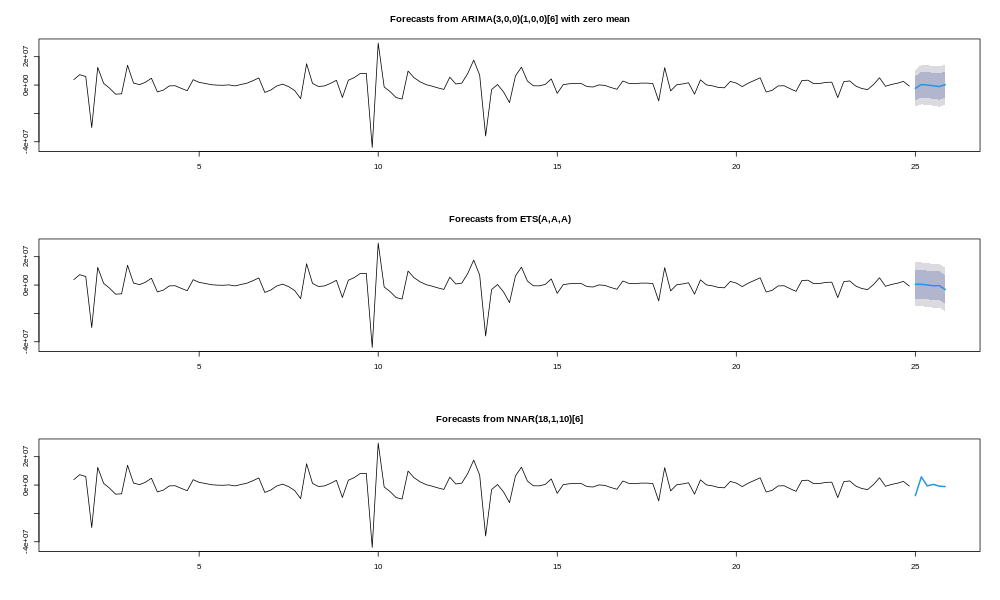

In [693]:
%%R -w 1000 -h 600

par(mfrow = c(3,1))
plot(prevArima24)
plot(prevHoltETS24)
plot(prevNeural24)

### Plots - Comparação de alguns ciclos para comparação

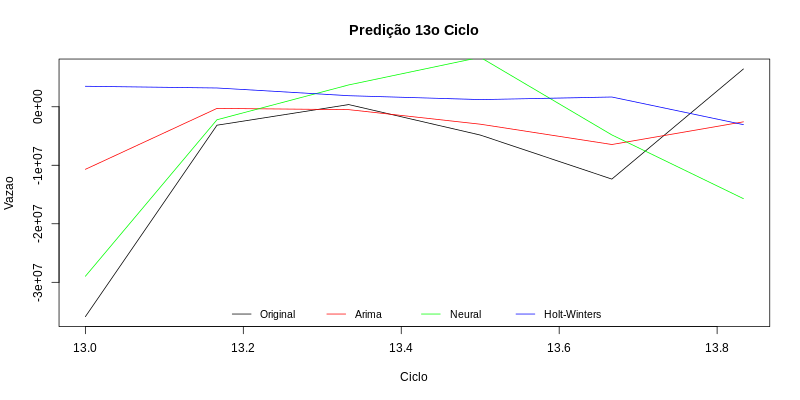

In [699]:
%%R -w 800 -h 400

plot(mytsTest13, main= "Predição 13o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima12$mean, col="red")
lines(prevNeural12$mean, col="green")
lines(prevHoltETS12$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

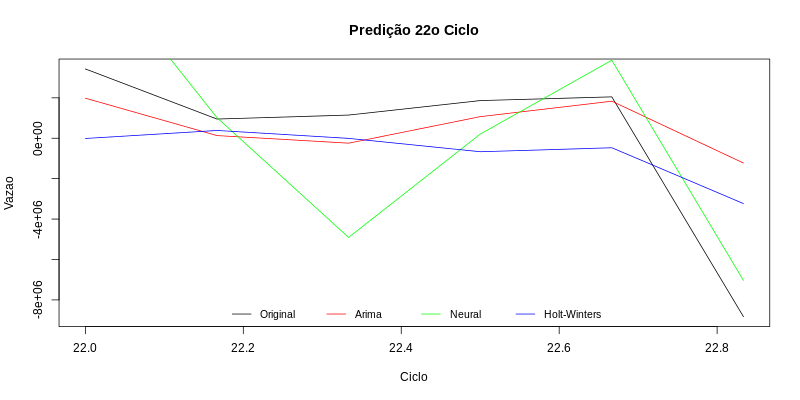

In [703]:
%%R -w 800 -h 400

plot(mytsTest22, main= "Predição 22o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima21$mean, col="red")
lines(prevNeural21$mean, col="green")
lines(prevHoltETS21$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

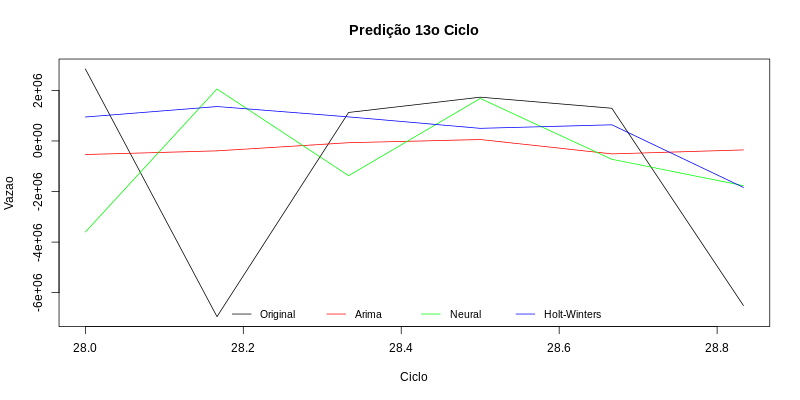

In [705]:
%%R -w 800 -h 400

plot(mytsTest28, main= "Predição 13o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima27$mean, col="red")
lines(prevNeural27$mean, col="green")
lines(prevHoltETS27$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

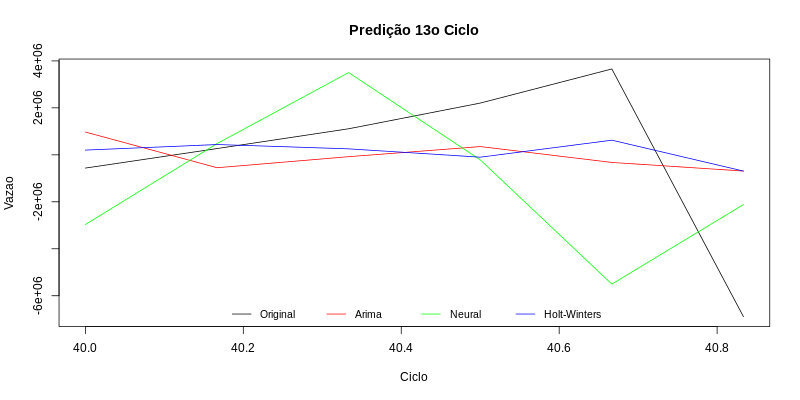

In [711]:
%%R -w 800 -h 400

plot(mytsTest40, main= "Predição 13o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima39$mean, col="red")
lines(prevNeural39$mean, col="green")
lines(prevHoltETS39$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

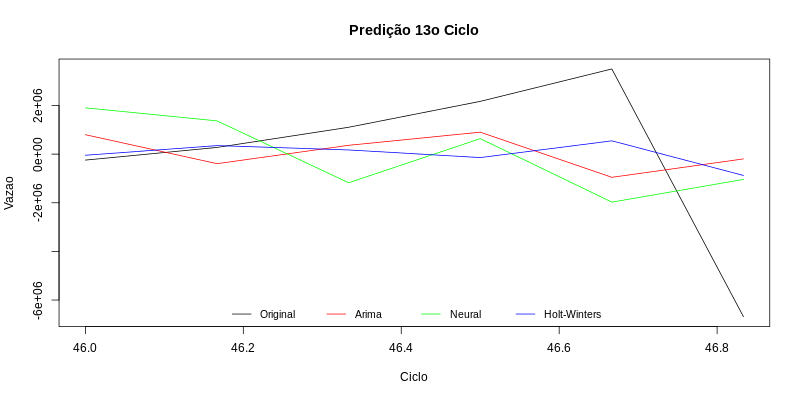

In [713]:
%%R -w 800 -h 400

plot(mytsTest46, main= "Predição 13o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima45$mean, col="red")
lines(prevNeural45$mean, col="green")
lines(prevHoltETS45$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

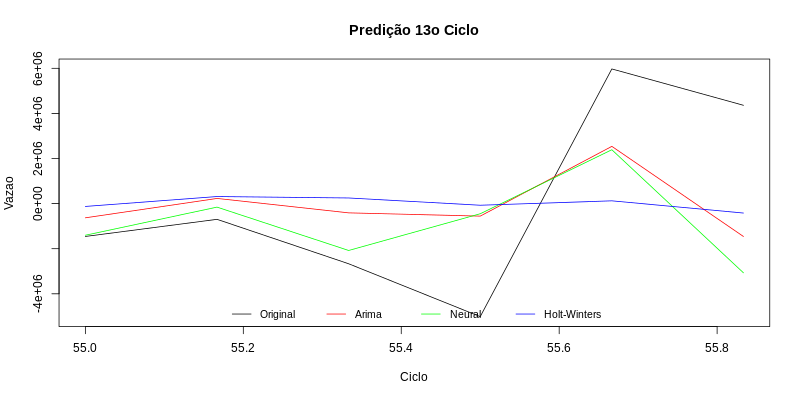

In [716]:
%%R -w 800 -h 400

plot(mytsTest55, main= "Predição 13o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima54$mean, col="red")
lines(prevNeural54$mean, col="green")
lines(prevHoltETS54$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

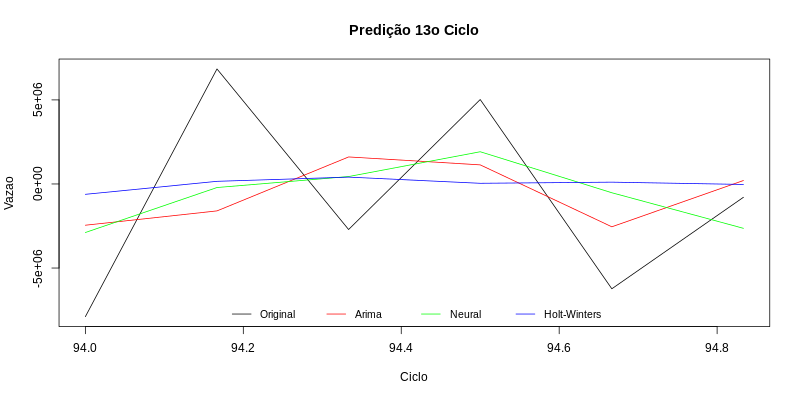

In [721]:
%%R -w 800 -h 400

plot(mytsTest94, main= "Predição 13o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima93$mean, col="red")
lines(prevNeural93$mean, col="green")
lines(prevHoltETS93$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

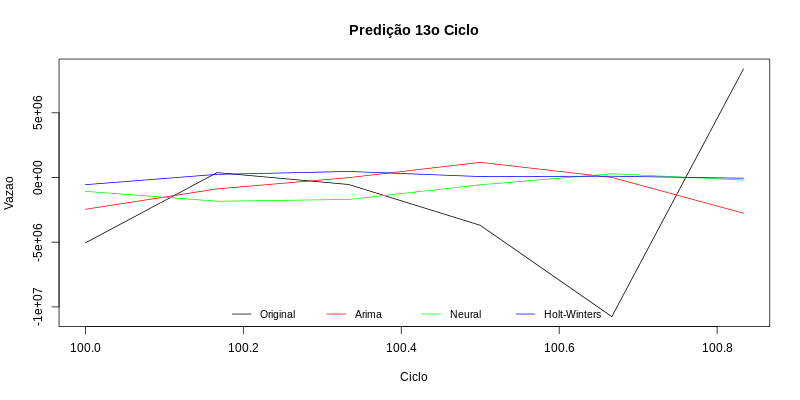

In [723]:
%%R -w 800 -h 400

plot(mytsTest100, main= "Predição 13o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima99$mean, col="red")
lines(prevNeural99$mean, col="green")
lines(prevHoltETS99$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

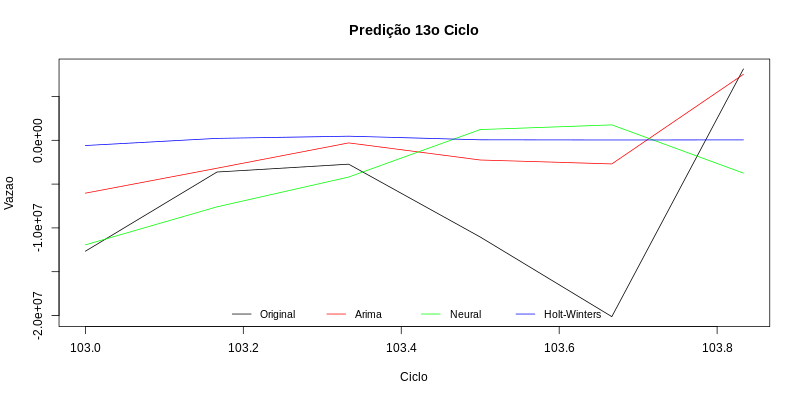

In [724]:
%%R -w 800 -h 400

plot(mytsTest103, main= "Predição 13o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima102$mean, col="red")
lines(prevNeural102$mean, col="green")
lines(prevHoltETS102$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

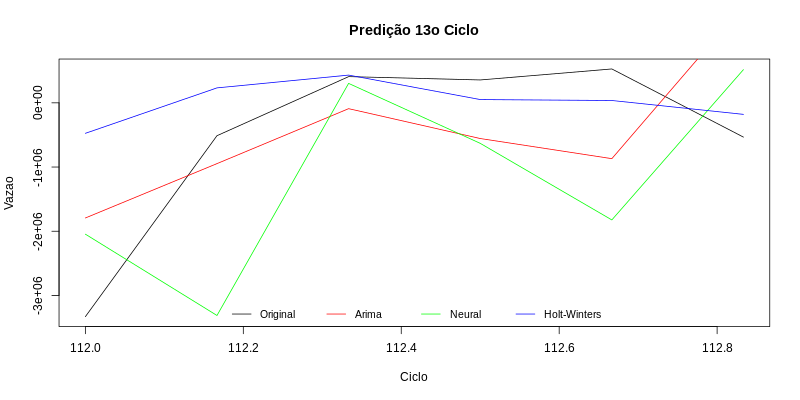

In [727]:
%%R -w 800 -h 400

plot(mytsTest112, main= "Predição 13o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima111$mean, col="red")
lines(prevNeural111$mean, col="green")
lines(prevHoltETS111$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

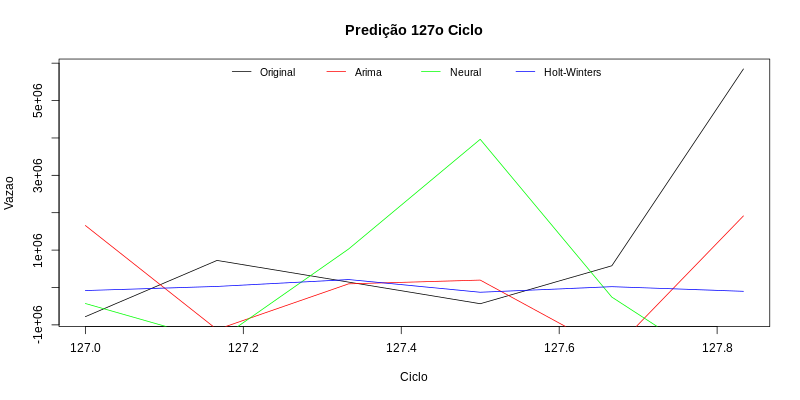

In [735]:
%%R -w 800 -h 400

plot(mytsTest127, main= "Predição 127o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima126$mean, col="red")
lines(prevNeural126$mean, col="green")
lines(prevHoltETS126$mean, col="blue")
legend("top", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

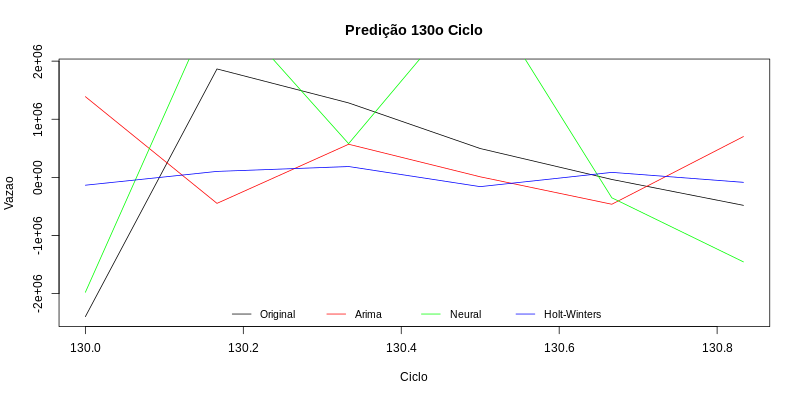

In [739]:
%%R -w 800 -h 400

plot(mytsTest130, main= "Predição 130o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima129$mean, col="red")
lines(prevNeural129$mean, col="green")
lines(prevHoltETS129$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

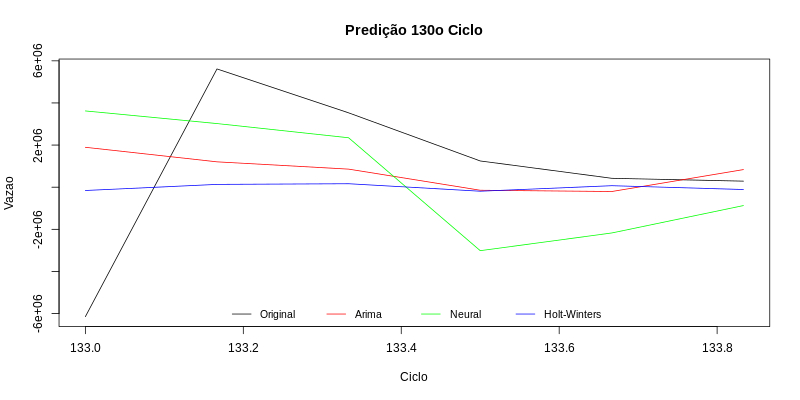

In [740]:
%%R -w 800 -h 400

plot(mytsTest133, main= "Predição 133o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima132$mean, col="red")
lines(prevNeural132$mean, col="green")
lines(prevHoltETS132$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

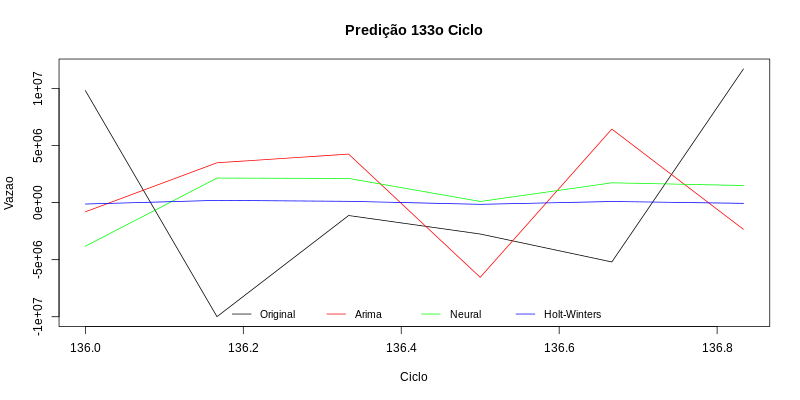

In [741]:
%%R -w 800 -h 400

plot(mytsTest136, main= "Predição 136o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima135$mean, col="red")
lines(prevNeural135$mean, col="green")
lines(prevHoltETS135$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

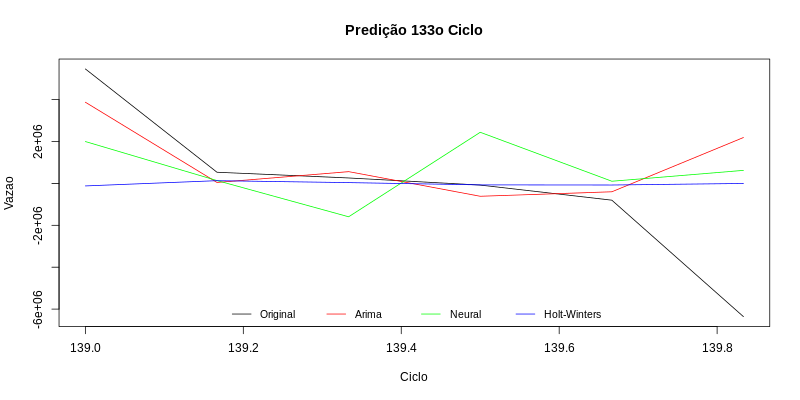

In [742]:
%%R -w 800 -h 400

plot(mytsTest139, main= "Predição 139o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima138$mean, col="red")
lines(prevNeural138$mean, col="green")
lines(prevHoltETS138$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

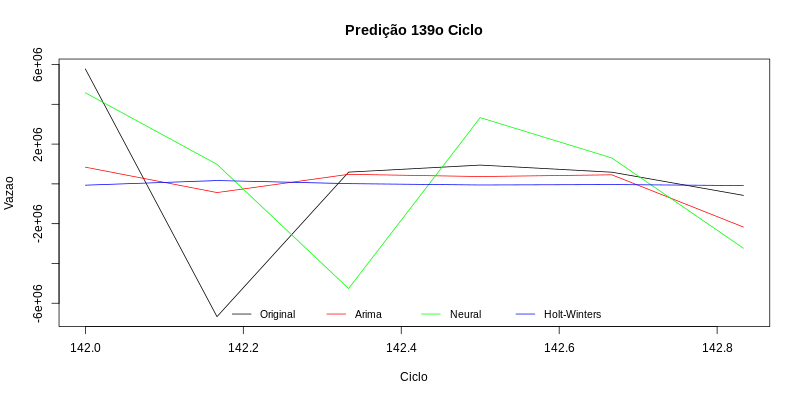

In [743]:
%%R -w 800 -h 400

plot(mytsTest142, main= "Predição 142o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima141$mean, col="red")
lines(prevNeural141$mean, col="green")
lines(prevHoltETS141$mean, col="blue")
legend("bottom", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

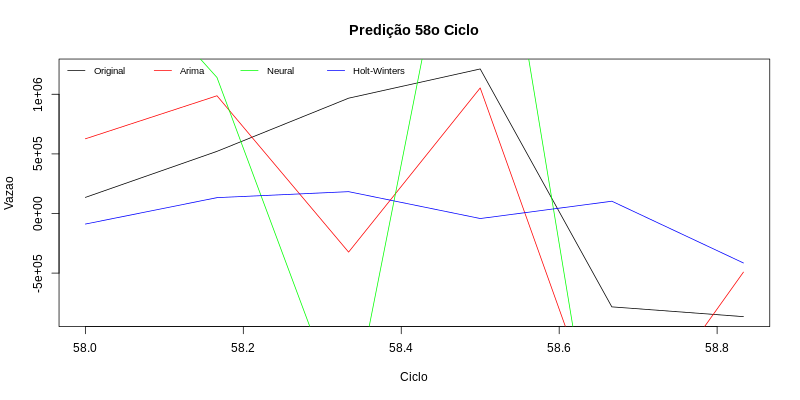

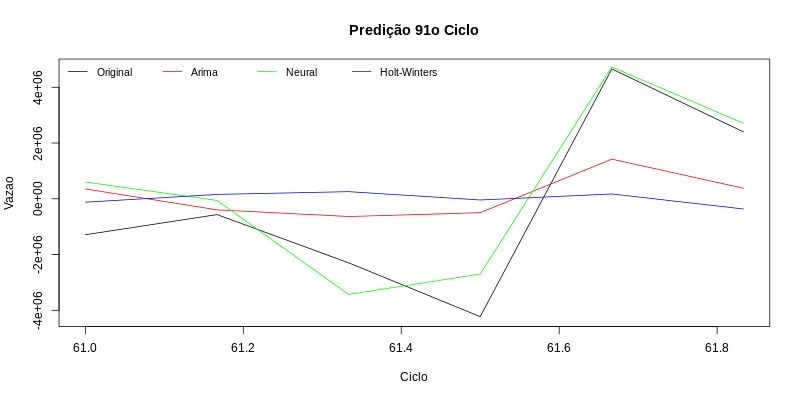

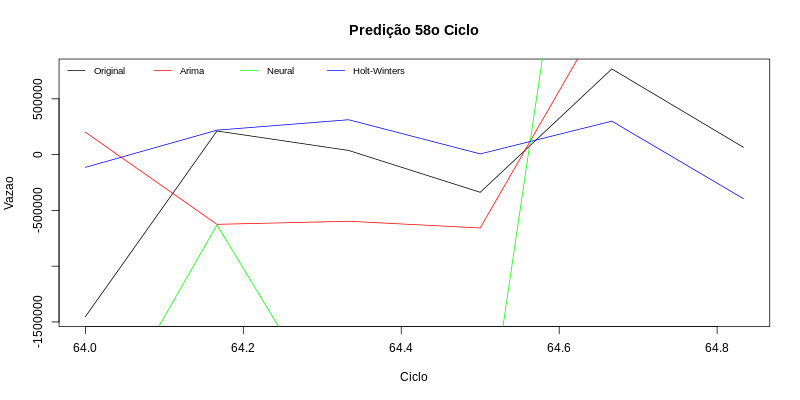

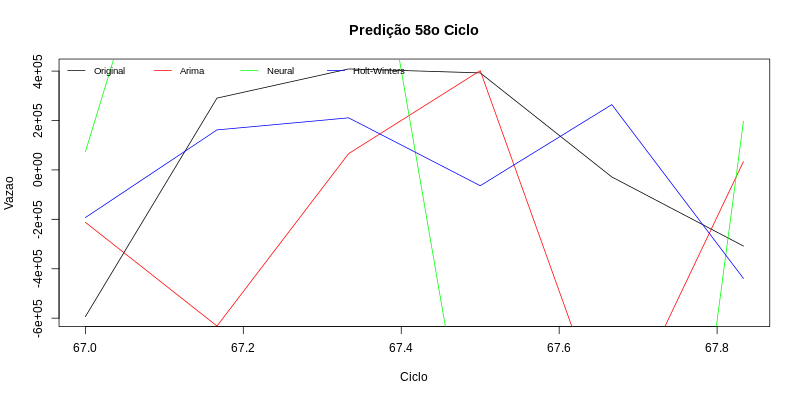

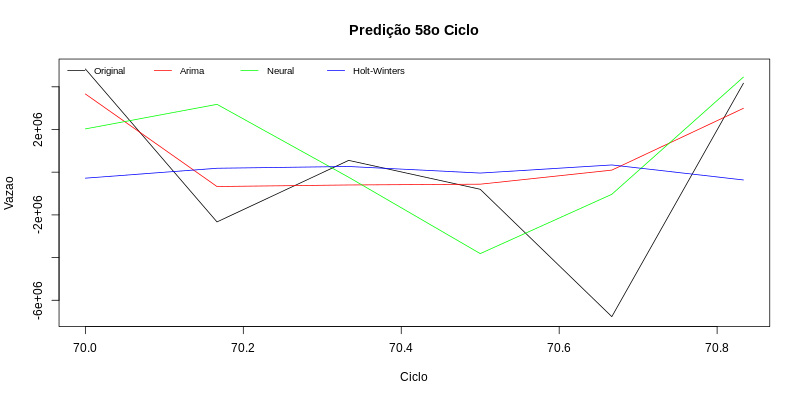

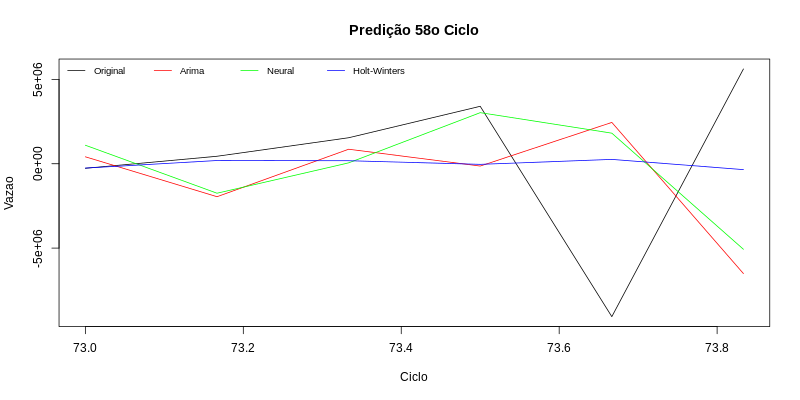

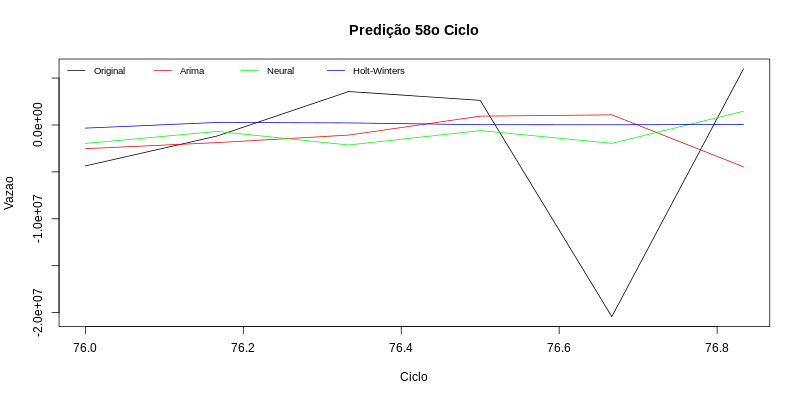

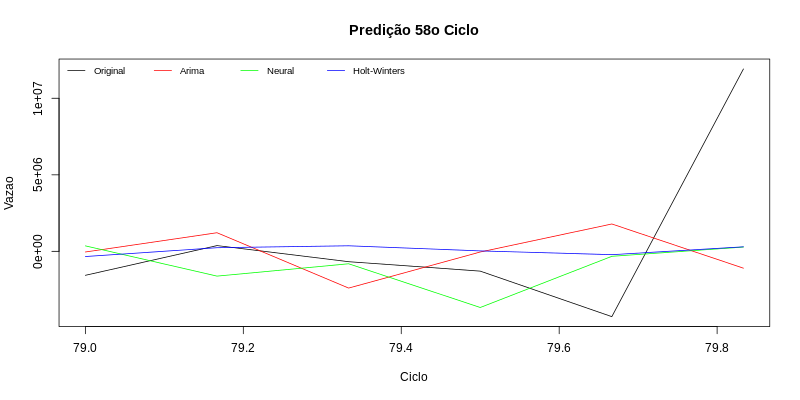

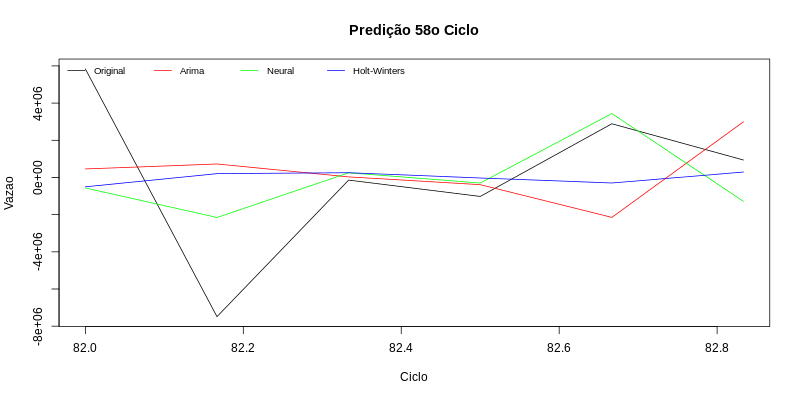

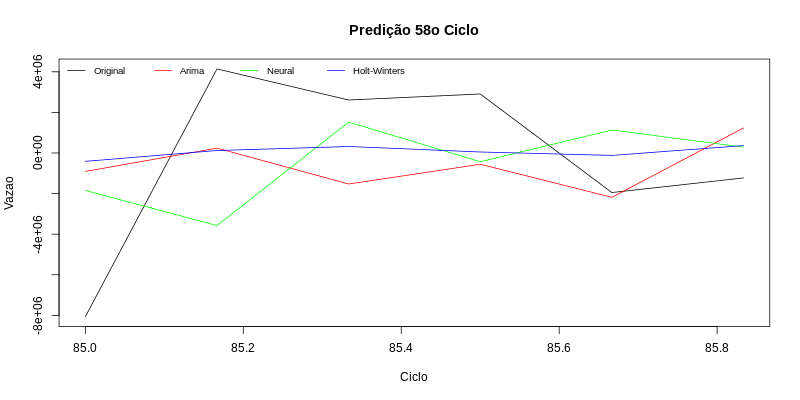

In [718]:
%%R -w 800 -h 400

plot(mytsTest58, main= "Predição 58o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima57$mean, col="red")
lines(prevNeural57$mean, col="green")
lines(prevHoltETS57$mean, col="blue")
legend("topleft", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest61, main= "Predição 91o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima60$mean, col="red")
lines(prevNeural60$mean, col="green")
lines(prevHoltETS60$mean, col="blue")
legend("topleft", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.87, bty = "n", horiz=T)

plot(mytsTest64, main= "Predição 58o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima63$mean, col="red")
lines(prevNeural63$mean, col="green")
lines(prevHoltETS63$mean, col="blue")
legend("topleft", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest67, main= "Predição 58o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima66$mean, col="red")
lines(prevNeural66$mean, col="green")
lines(prevHoltETS66$mean, col="blue")
legend("topleft", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest70, main= "Predição 58o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima69$mean, col="red")
lines(prevNeural69$mean, col="green")
lines(prevHoltETS69$mean, col="blue")
legend("topleft", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest73, main= "Predição 58o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima72$mean, col="red")
lines(prevNeural72$mean, col="green")
lines(prevHoltETS72$mean, col="blue")
legend("topleft", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest76, main= "Predição 58o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima75$mean, col="red")
lines(prevNeural75$mean, col="green")
lines(prevHoltETS75$mean, col="blue")
legend("topleft", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest79, main= "Predição 58o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima78$mean, col="red")
lines(prevNeural78$mean, col="green")
lines(prevHoltETS78$mean, col="blue")
legend("topleft", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest82, main= "Predição 58o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima81$mean, col="red")
lines(prevNeural81$mean, col="green")
lines(prevHoltETS81$mean, col="blue")
legend("topleft", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

plot(mytsTest85, main= "Predição 58o Ciclo", xlab="Ciclo", ylab="Vazao")
lines(prevArima84$mean, col="red")
lines(prevNeural84$mean, col="green")
lines(prevHoltETS84$mean, col="blue")
legend("topleft", legend = c("Original", "Arima", "Neural","Holt-Winters"), 
       col = c("black", "red","green","blue"), lty=1:1, cex=0.8, bty = "n", horiz=T)

## Avaliação

### RMSE

In [843]:
%%R 

Arima_RMSE = c(
  rmse(mytsTest4, prevArima3$mean)/10000,
  rmse(mytsTest7, prevArima6$mean)/10000,
  rmse(mytsTest10, prevArima9$mean)/10000,
  rmse(mytsTest13, prevArima12$mean)/10000,
  rmse(mytsTest16, prevArima15$mean)/10000,
  rmse(mytsTest19, prevArima18$mean)/10000,
  rmse(mytsTest22, prevArima21$mean)/10000,
  rmse(mytsTest25, prevArima24$mean)/10000,
  rmse(mytsTest28, prevArima27$mean)/10000,
  rmse(mytsTest31, prevArima30$mean)/10000,
  rmse(mytsTest34, prevArima33$mean)/10000,
  rmse(mytsTest37, prevArima36$mean)/10000,
  rmse(mytsTest40, prevArima39$mean)/10000,
  rmse(mytsTest43, prevArima42$mean)/10000,
  rmse(mytsTest46, prevArima45$mean)/10000,
  rmse(mytsTest49, prevArima48$mean)/10000,
  rmse(mytsTest52, prevArima51$mean)/10000,
  rmse(mytsTest55, prevArima54$mean)/10000,
  rmse(mytsTest58, prevArima57$mean)/10000,
  rmse(mytsTest61, prevArima60$mean)/10000,
  rmse(mytsTest64, prevArima63$mean)/10000,
  rmse(mytsTest67, prevArima66$mean)/10000,
  rmse(mytsTest70, prevArima69$mean)/10000,
  rmse(mytsTest73, prevArima72$mean)/10000,
  rmse(mytsTest76, prevArima75$mean)/10000,
  rmse(mytsTest79, prevArima78$mean)/10000,
  rmse(mytsTest82, prevArima81$mean)/10000,
  rmse(mytsTest85, prevArima84$mean)/10000,
  rmse(mytsTest88, prevArima87$mean)/10000,
  rmse(mytsTest91, prevArima90$mean)/10000,
  rmse(mytsTest94, prevArima93$mean)/10000,
  rmse(mytsTest97, prevArima96$mean)/10000,
  rmse(mytsTest100, prevArima99$mean)/10000,
  rmse(mytsTest103, prevArima102$mean)/10000,
  rmse(mytsTest106, prevArima105$mean)/10000,
  rmse(mytsTest109, prevArima108$mean)/10000,
  rmse(mytsTest112, prevArima111$mean)/10000,
  rmse(mytsTest115, prevArima114$mean)/10000,
  rmse(mytsTest118, prevArima117$mean)/10000,
  rmse(mytsTest121, prevArima120$mean)/10000,
  rmse(mytsTest124, prevArima123$mean)/10000,
  rmse(mytsTest127, prevArima126$mean)/10000,
  rmse(mytsTest130, prevArima129$mean)/10000,
  rmse(mytsTest133, prevArima132$mean)/10000,
  rmse(mytsTest136, prevArima135$mean)/10000,
  rmse(mytsTest139, prevArima138$mean)/10000,
  rmse(mytsTest142, prevArima141$mean)/10000
)


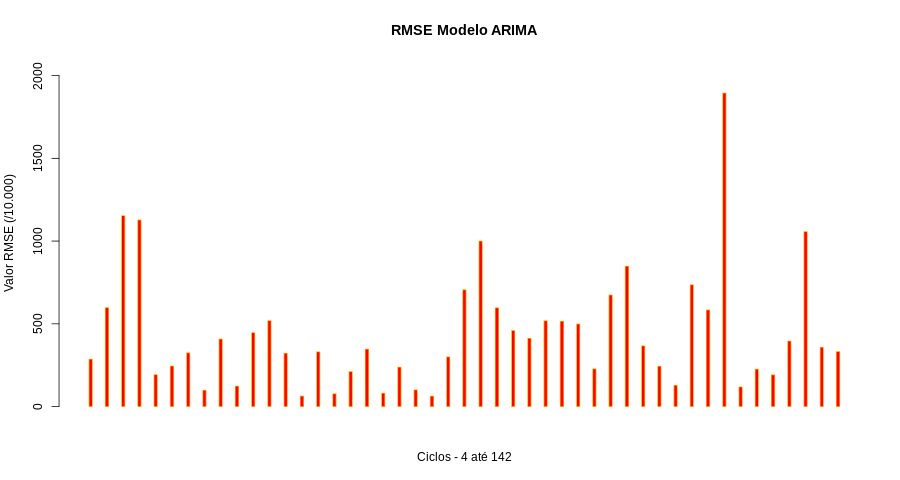

In [890]:
%%R -w 900

barplot(Arima_RMSE, main = 'RMSE Modelo ARIMA', xlab = 'Ciclos - 4 até 142', ylab = 'Valor RMSE (/10.000)',
        xpd = FALSE, ylim = c(0,2100),
        space = 4 ,col = 'red', border = 'orange')

In [883]:
%%R 

Neural_RMSE = c(
  rmse(mytsTest4, prevNeural3$mean)/10000,
  rmse(mytsTest7, prevNeural6$mean)/10000,
  rmse(mytsTest10, prevNeural9$mean)/10000,
  rmse(mytsTest13, prevNeural12$mean)/10000,
  rmse(mytsTest16, prevNeural15$mean)/10000,
  rmse(mytsTest19, prevNeural18$mean)/10000,
  rmse(mytsTest22, prevNeural21$mean)/10000,
  rmse(mytsTest25, prevNeural24$mean)/10000,
  rmse(mytsTest28, prevNeural27$mean)/10000,
  rmse(mytsTest31, prevNeural30$mean)/10000,
  rmse(mytsTest34, prevNeural33$mean)/10000,
  rmse(mytsTest37, prevNeural36$mean)/10000,
  rmse(mytsTest40, prevNeural39$mean)/10000,
  rmse(mytsTest43, prevNeural42$mean)/10000,
  rmse(mytsTest46, prevNeural45$mean)/10000,
  rmse(mytsTest49, prevNeural48$mean)/10000,
  rmse(mytsTest52, prevNeural51$mean)/10000,
  rmse(mytsTest55, prevNeural54$mean)/10000,
  rmse(mytsTest58, prevNeural57$mean)/10000,
  rmse(mytsTest61, prevNeural60$mean)/10000,
  rmse(mytsTest64, prevNeural63$mean)/10000,
  rmse(mytsTest67, prevNeural66$mean)/10000,
  rmse(mytsTest70, prevNeural69$mean)/10000,
  rmse(mytsTest73, prevNeural72$mean)/10000,
  rmse(mytsTest76, prevNeural75$mean)/10000,
  rmse(mytsTest79, prevNeural78$mean)/10000,
  rmse(mytsTest82, prevNeural81$mean)/10000,
  rmse(mytsTest85, prevNeural84$mean)/10000,
  rmse(mytsTest88, prevNeural87$mean)/10000,
  rmse(mytsTest91, prevNeural90$mean)/10000,
  rmse(mytsTest94, prevNeural93$mean)/10000,
  rmse(mytsTest97, prevNeural96$mean)/10000,
  rmse(mytsTest100, prevNeural99$mean)/10000,
  rmse(mytsTest103, prevNeural102$mean)/10000,
  rmse(mytsTest106, prevNeural105$mean)/10000,
  rmse(mytsTest109, prevNeural108$mean)/10000,
  rmse(mytsTest112, prevNeural111$mean)/10000,
  rmse(mytsTest115, prevNeural114$mean)/10000,
  rmse(mytsTest118, prevNeural117$mean)/10000,
  rmse(mytsTest121, prevNeural120$mean)/10000,
  rmse(mytsTest124, prevNeural123$mean)/10000,
  rmse(mytsTest127, prevNeural126$mean)/10000,
  rmse(mytsTest130, prevNeural129$mean)/10000,
  rmse(mytsTest133, prevNeural132$mean)/10000,
  rmse(mytsTest136, prevNeural135$mean)/10000,
  rmse(mytsTest139, prevNeural138$mean)/10000,
  rmse(mytsTest142, prevNeural141$mean)/10000
)

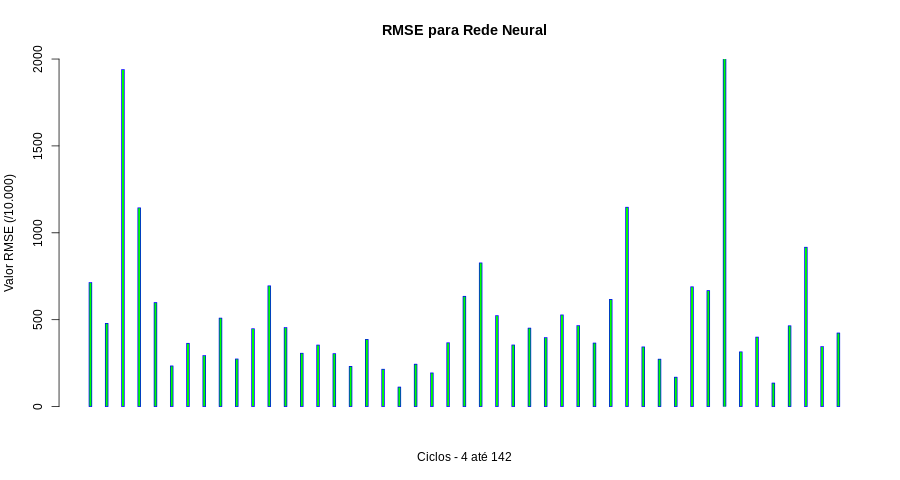

In [907]:
%%R -w 900

barplot(Neural_RMSE, main = 'RMSE para Rede Neural', xlab = 'Ciclos - 4 até 142', ylab = 'Valor RMSE (/10.000)',
        xpd = FALSE, ylim = c(0,2000),
        space = 5 ,col = 'green', border = 'blue')

In [893]:
%%R

HoltETS_RMSE = c(
  rmse(mytsTest4, prevHoltETS3$mean)/10000,
  rmse(mytsTest7, prevHoltETS6$mean)/10000,
  rmse(mytsTest10, prevHoltETS9$mean)/10000,
  rmse(mytsTest13, prevHoltETS12$mean)/10000,
  rmse(mytsTest16, prevHoltETS15$mean)/10000,
  rmse(mytsTest19, prevHoltETS18$mean)/10000,
  rmse(mytsTest22, prevHoltETS21$mean)/10000,
  rmse(mytsTest25, prevHoltETS24$mean)/10000,
  rmse(mytsTest28, prevHoltETS27$mean)/10000,
  rmse(mytsTest31, prevHoltETS30$mean)/10000,
  rmse(mytsTest34, prevHoltETS33$mean)/10000,
  rmse(mytsTest37, prevHoltETS36$mean)/10000,
  rmse(mytsTest40, prevHoltETS39$mean)/10000,
  rmse(mytsTest43, prevHoltETS42$mean)/10000,
  rmse(mytsTest46, prevHoltETS45$mean)/10000,
  rmse(mytsTest49, prevHoltETS48$mean)/10000,
  rmse(mytsTest52, prevHoltETS51$mean)/10000,
  rmse(mytsTest55, prevHoltETS54$mean)/10000,
  rmse(mytsTest58, prevHoltETS57$mean)/10000,
  rmse(mytsTest61, prevHoltETS60$mean)/10000,
  rmse(mytsTest64, prevHoltETS63$mean)/10000,
  rmse(mytsTest67, prevHoltETS66$mean)/10000,
  rmse(mytsTest70, prevHoltETS69$mean)/10000,
  rmse(mytsTest73, prevHoltETS72$mean)/10000,
  rmse(mytsTest76, prevHoltETS75$mean)/10000,
  rmse(mytsTest79, prevHoltETS78$mean)/10000,
  rmse(mytsTest82, prevHoltETS81$mean)/10000,
  rmse(mytsTest85, prevHoltETS84$mean)/10000,
  rmse(mytsTest88, prevHoltETS87$mean)/10000,
  rmse(mytsTest91, prevHoltETS90$mean)/10000,
  rmse(mytsTest94, prevHoltETS93$mean)/10000,
  rmse(mytsTest97, prevHoltETS96$mean)/10000,
  rmse(mytsTest100, prevHoltETS99$mean)/10000,
  rmse(mytsTest103, prevHoltETS102$mean)/10000,
  rmse(mytsTest106, prevHoltETS105$mean)/10000,
  rmse(mytsTest109, prevHoltETS108$mean)/10000,
  rmse(mytsTest112, prevHoltETS111$mean)/10000,
  rmse(mytsTest115, prevHoltETS114$mean)/10000,
  rmse(mytsTest118, prevHoltETS117$mean)/10000,
  rmse(mytsTest121, prevHoltETS120$mean)/10000,
  rmse(mytsTest124, prevHoltETS123$mean)/10000,
  rmse(mytsTest127, prevHoltETS126$mean)/10000,
  rmse(mytsTest130, prevHoltETS129$mean)/10000,
  rmse(mytsTest133, prevHoltETS132$mean)/10000,
  rmse(mytsTest136, prevHoltETS135$mean)/10000,
  rmse(mytsTest139, prevHoltETS138$mean)/10000,
  rmse(mytsTest142, prevHoltETS141$mean)/10000
)


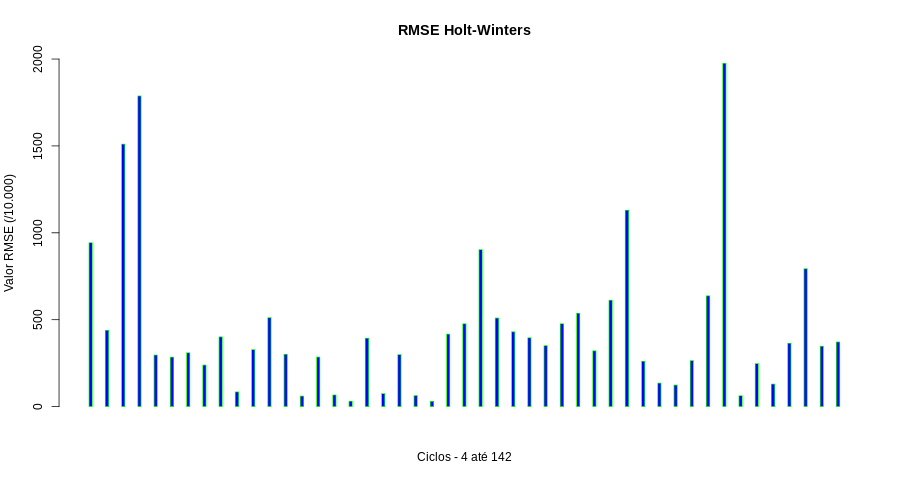

In [908]:
%%R -w 900

barplot(HoltETS_RMSE, main = 'RMSE Holt-Winters', xlab = 'Ciclos - 4 até 142', ylab = 'Valor RMSE (/10.000)',
        xpd = FALSE, ylim = c(0,2000),
        space = 4 ,col = 'blue', border = 'green')

### MAPE

In [910]:
%%R 

Arima_mape = c(
  mape(mytsTest4, prevArima3$mean),
  mape(mytsTest7, prevArima6$mean),
  mape(mytsTest10, prevArima9$mean),
  mape(mytsTest13, prevArima12$mean),
  mape(mytsTest16, prevArima15$mean),
  mape(mytsTest19, prevArima18$mean),
  mape(mytsTest22, prevArima21$mean),
  mape(mytsTest25, prevArima24$mean),
  mape(mytsTest28, prevArima27$mean),
  mape(mytsTest31, prevArima30$mean),
  mape(mytsTest34, prevArima33$mean),
  mape(mytsTest37, prevArima36$mean),
  mape(mytsTest40, prevArima39$mean),
  mape(mytsTest43, prevArima42$mean),
  mape(mytsTest46, prevArima45$mean),
  mape(mytsTest49, prevArima48$mean),
  mape(mytsTest52, prevArima51$mean),
  mape(mytsTest55, prevArima54$mean),
  mape(mytsTest58, prevArima57$mean),
  mape(mytsTest61, prevArima60$mean),
  mape(mytsTest64, prevArima63$mean),
  mape(mytsTest67, prevArima66$mean),
  mape(mytsTest70, prevArima69$mean),
  mape(mytsTest73, prevArima72$mean),
  mape(mytsTest76, prevArima75$mean),
  mape(mytsTest79, prevArima78$mean),
  mape(mytsTest82, prevArima81$mean),
  mape(mytsTest85, prevArima84$mean),
  mape(mytsTest88, prevArima87$mean),
  mape(mytsTest91, prevArima90$mean),
  mape(mytsTest94, prevArima93$mean),
  mape(mytsTest97, prevArima96$mean),
  mape(mytsTest100, prevArima99$mean),
  mape(mytsTest103, prevArima102$mean),
  mape(mytsTest106, prevArima105$mean),
  mape(mytsTest109, prevArima108$mean),
  mape(mytsTest112, prevArima111$mean),
  mape(mytsTest115, prevArima114$mean),
  mape(mytsTest118, prevArima117$mean),
  mape(mytsTest121, prevArima120$mean),
  mape(mytsTest124, prevArima123$mean),
  mape(mytsTest127, prevArima126$mean),
  mape(mytsTest130, prevArima129$mean),
  mape(mytsTest133, prevArima132$mean),
  mape(mytsTest136, prevArima135$mean),
  mape(mytsTest139, prevArima138$mean),
  mape(mytsTest142, prevArima141$mean)
)


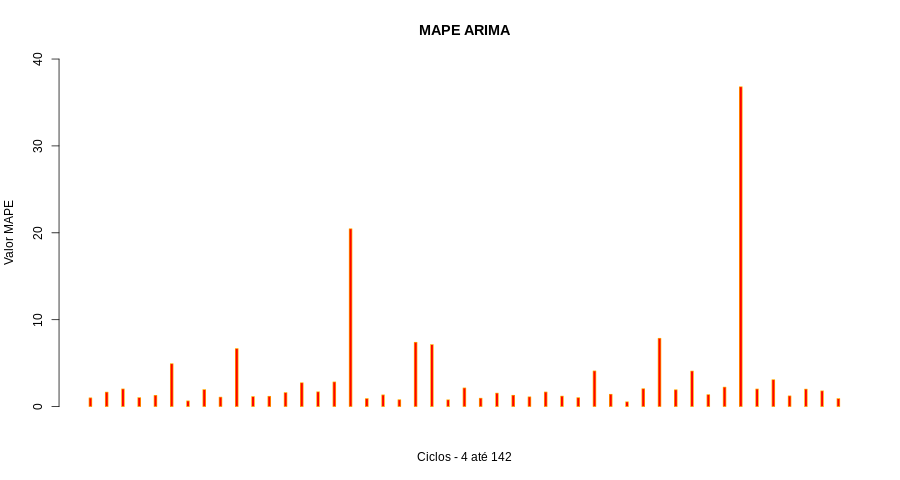

In [925]:
%%R -w 900

barplot(Arima_mape, main = 'MAPE ARIMA', xlab = 'Ciclos - 4 até 142', ylab = 'Valor MAPE',
        xpd = FALSE, ylim = c(0,40),
        space = 5 ,col = 'red', border = 'orange')

In [913]:
%%R

Neural_mape = c(
  mape(mytsTest4, prevNeural3$mean),
  mape(mytsTest7, prevNeural6$mean),
  mape(mytsTest10, prevNeural9$mean),
  mape(mytsTest13, prevNeural12$mean),
  mape(mytsTest16, prevNeural15$mean),
  mape(mytsTest19, prevNeural18$mean),
  mape(mytsTest22, prevNeural21$mean),
  mape(mytsTest25, prevNeural24$mean),
  mape(mytsTest28, prevNeural27$mean),
  mape(mytsTest31, prevNeural30$mean),
  mape(mytsTest34, prevNeural33$mean),
  mape(mytsTest37, prevNeural36$mean),
  mape(mytsTest40, prevNeural39$mean),
  mape(mytsTest43, prevNeural42$mean),
  mape(mytsTest46, prevNeural45$mean),
  mape(mytsTest49, prevNeural48$mean),
  mape(mytsTest52, prevNeural51$mean),
  mape(mytsTest55, prevNeural54$mean),
  mape(mytsTest58, prevNeural57$mean),
  mape(mytsTest61, prevNeural60$mean),
  mape(mytsTest64, prevNeural63$mean),
  mape(mytsTest67, prevNeural66$mean),
  mape(mytsTest70, prevNeural69$mean),
  mape(mytsTest73, prevNeural72$mean),
  mape(mytsTest76, prevNeural75$mean),
  mape(mytsTest79, prevNeural78$mean),
  mape(mytsTest82, prevNeural81$mean),
  mape(mytsTest85, prevNeural84$mean),
  mape(mytsTest88, prevNeural87$mean),
  mape(mytsTest91, prevNeural90$mean),
  mape(mytsTest94, prevNeural93$mean),
  mape(mytsTest97, prevNeural96$mean),
  mape(mytsTest100, prevNeural99$mean),
  mape(mytsTest103, prevNeural102$mean),
  mape(mytsTest106, prevNeural105$mean),
  mape(mytsTest109, prevNeural108$mean),
  mape(mytsTest112, prevNeural111$mean),
  mape(mytsTest115, prevNeural114$mean),
  mape(mytsTest118, prevNeural117$mean),
  mape(mytsTest121, prevNeural120$mean),
  mape(mytsTest124, prevNeural123$mean),
  mape(mytsTest127, prevNeural126$mean),
  mape(mytsTest130, prevNeural129$mean),
  mape(mytsTest133, prevNeural132$mean),
  mape(mytsTest136, prevNeural135$mean),
  mape(mytsTest139, prevNeural138$mean),
  mape(mytsTest142, prevNeural141$mean)
)


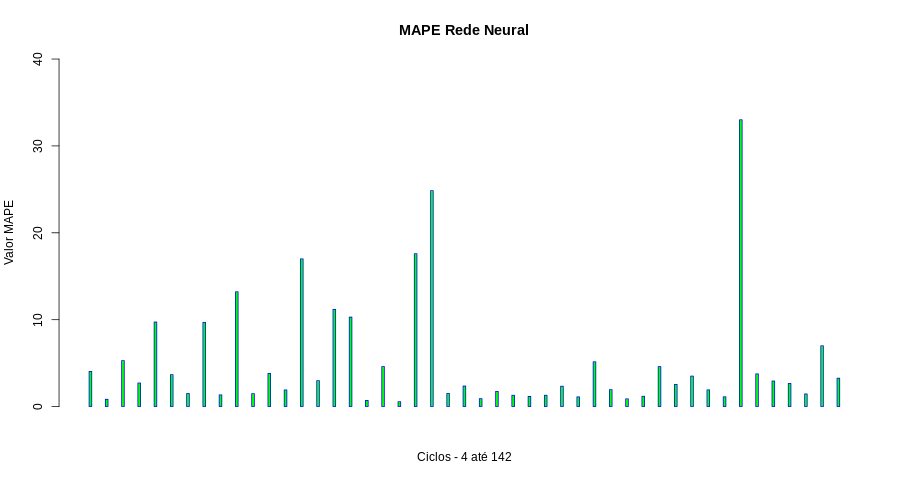

In [930]:
%%R -w 900

barplot(Neural_mape, main = 'MAPE Rede Neural', xlab = 'Ciclos - 4 até 142', ylab = 'Valor MAPE',
        xpd = FALSE, ylim = c(0,40),
        space = 5 ,col = 'green', border = 'blue')

In [ ]:
%%R

HoltETS_mape = c(
  mape(mytsTest4, prevHoltETS3$mean),
  mape(mytsTest7, prevHoltETS6$mean),
  mape(mytsTest10, prevHoltETS9$mean),
  mape(mytsTest13, prevHoltETS12$mean),
  mape(mytsTest16, prevHoltETS15$mean),
  mape(mytsTest19, prevHoltETS18$mean),
  mape(mytsTest22, prevHoltETS21$mean),
  mape(mytsTest25, prevHoltETS24$mean),
  mape(mytsTest28, prevHoltETS27$mean),
  mape(mytsTest31, prevHoltETS30$mean),
  mape(mytsTest34, prevHoltETS33$mean),
  mape(mytsTest37, prevHoltETS36$mean),
  mape(mytsTest40, prevHoltETS39$mean),
  mape(mytsTest43, prevHoltETS42$mean),
  mape(mytsTest46, prevHoltETS45$mean),
  mape(mytsTest49, prevHoltETS48$mean),
  mape(mytsTest52, prevHoltETS51$mean),
  mape(mytsTest55, prevHoltETS54$mean),
  mape(mytsTest58, prevHoltETS57$mean),
  mape(mytsTest61, prevHoltETS60$mean),
  mape(mytsTest64, prevHoltETS63$mean),
  mape(mytsTest67, prevHoltETS66$mean),
  mape(mytsTest70, prevHoltETS69$mean),
  mape(mytsTest73, prevHoltETS72$mean),
  mape(mytsTest76, prevHoltETS75$mean),
  mape(mytsTest79, prevHoltETS78$mean),
  mape(mytsTest82, prevHoltETS81$mean),
  mape(mytsTest85, prevHoltETS84$mean),
  mape(mytsTest88, prevHoltETS87$mean),
  mape(mytsTest91, prevHoltETS90$mean),
  mape(mytsTest94, prevHoltETS93$mean),
  mape(mytsTest97, prevHoltETS96$mean),
  mape(mytsTest100, prevHoltETS99$mean),
  mape(mytsTest103, prevHoltETS102$mean),
  mape(mytsTest106, prevHoltETS105$mean),
  mape(mytsTest109, prevHoltETS108$mean),
  mape(mytsTest112, prevHoltETS111$mean),
  mape(mytsTest115, prevHoltETS114$mean),
  mape(mytsTest118, prevHoltETS117$mean),
  mape(mytsTest121, prevHoltETS120$mean),
  mape(mytsTest124, prevHoltETS123$mean),
  mape(mytsTest127, prevHoltETS126$mean),
  mape(mytsTest130, prevHoltETS129$mean),
  mape(mytsTest133, prevHoltETS132$mean),
  mape(mytsTest136, prevHoltETS135$mean),
  mape(mytsTest139, prevHoltETS138$mean),
  mape(mytsTest142, prevHoltETS141$mean)
)


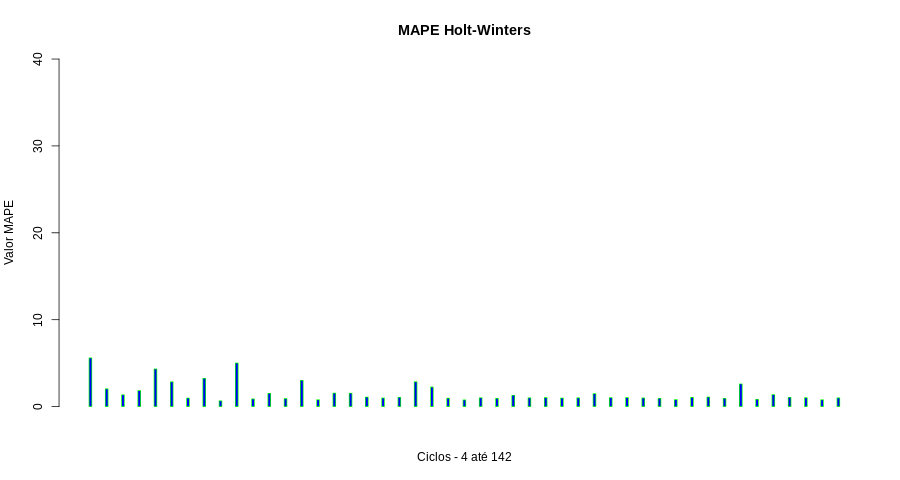

In [931]:
%%R -w 900

barplot(HoltETS_mape, main = 'MAPE Holt-Winters', xlab = 'Ciclos - 4 até 142', ylab = 'Valor MAPE',
        xpd = FALSE, ylim = c(0,40),
        space = 5 ,col = 'blue', border = 'green')